<a id='back_to_top'></a>

# Table of Content

- ### [Imports and Functions](#imports_n_functions)
- ### [Loading the features and data types](#loading_features)
- ### [Loading target and initial data analysis](#loading_target)
- ### [K - Means](#kmeans)
    

[back to top](#back_to_top)  <a id='imports_n_functions'></a>

In [1]:
import matplotlib
matplotlib.use('nbagg')

import os
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.stats as stats
import random
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
import pandas as pd
import time
import seaborn as sb

In [2]:
# Set Pandas to display more columns as default
pd.options.display.max_columns=30

The following line is for preventing warnings raised for operations done on copied slices of data frames. See [here](#https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas) mid-page for more info.   
In short, as the default state for the copy action is 'deep = True', the data-frame that is created is indeed a copy and not a *view*, and so actions on it won't change the original frame it is copied from. 

In [98]:
pd.options.mode.chained_assignment = None

Loading data from pickle

In [3]:
def read_data_from_pickle(file_name, sort = True, by_column = 'dim_user_gid'): 
    
    data = pd.read_pickle(file_name)
    data["dim_user_gid"].astype(int)

    print("\nA short summary of the uploaded file:")
    print("The data was loaded into a data-frame.")
    print("There are {} different rows, and {} different columns.".format(data.shape[0], data.shape[1]))
    print("There are {} unique values at the dim_user_gid column.".format(data['dim_user_gid'].nunique()))
    print("There are {} *nan* values at the dim_user_gid column.".format(data['dim_user_gid'].isnull().sum()))

    if sort:
        data = data.sort_values(by = ["dim_user_gid"])
        print("The data-frame was sorted by the dim_user_gid column.\n")
    
    return data

Data-frames related

In [4]:
def find_users_in_both_data_and_target_frames(data_frame, target_frame, sort = True, by_column = 'dim_user_gid'):
    
    result = data_frame.join(target_frame.set_index('dim_user_gid'), how="inner")
    
    print("\nA short summary:")
    print("The target frame was merged with the historical data frame, and it includes *only* users that appears in both.")
    print("There are {} different rows, and {} different columns.".format(result.shape[0], result.shape[1]))
    print("There are {} *nan* values at the dim_user_gid column.".format((result.shape[0] - result['dim_user_gid'].count())))
    print("There are {} unique values at the dim_user_gid column.".format(result['dim_user_gid'].nunique()))
    
    result = result.drop_duplicates(subset=["dim_user_gid"], keep='last')
    if sort:
        result = result.sort_values(by = ['dim_user_gid'])
        
    print("\nKeeping only the last entry of each duplicate.\nThe end data frame has {} rows.".format(result.shape[0]))
    print("It was sorted by the dim_user_gid column.\n")
    
    return result

Plotting 

In [5]:
def hist_of_numerical_feature(data_frame, column, n_bins, figure_size = (10, 6)):

    x = data_frame[column].to_numpy()
    plt.figure(figsize=figure_size)
    n, bins, patches = plt.hist(x, bins=n_bins, edgecolor='black')
    ticks = 0.5 * np.diff(bins) + bins[:-1]
    plt.xticks(ticks, np.ceil(ticks))
    
    # after plotting the data, format the labels
    current_values = plt.gca().get_xticks()
    # using format string '{:.0f}' here but you can choose others
    plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])
    plt.xticks(rotation=90)

    # Set x-axis label
    plt.xlabel(column, labelpad=20, size=16)
    plt.ylabel("Count", labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)

    plt.show()

In [6]:
def get_hist_info(x, n_bins): 
    
    n, bins, patches = plt.hist(x, bins=n_bins)
    plt.close()

    return n ,bins, patches

In [7]:
def plot_loglog_scale(data_frame, column, n_bins, figure_size = (10, 6)):

    x = data_frame[column].to_numpy()
    counts, bins, patches = get_hist_info(x, n_bins)
    bins_center = 0.5 * np.diff(bins) + bins[:-1]
    
    plt.figure(figsize=figure_size)
        
    plt.loglog(bins_center, counts, '.-')

    plt.xlabel('$log_{10}$' + '({}) '.format(column), labelpad=20, size=16)
    plt.ylabel('$log_{10}$ (counts) ', labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)
    
    plt.show()

In [8]:
def plot_data_by_index(data_frame, column, marker_size = 0.5, figure_size = (10, 6)): 
    
    plt.figure(figsize=figure_size)
    plt.plot(range(data_frame[column].shape[0]), data_frame[column], '.', markersize = marker_size)
    plt.xlabel('Index in Data', labelpad=20, size=16)
    plt.ylabel(column, labelpad=20, size=16)
    sb.despine(top=True, right=True, left=False, bottom=False)

    plt.show()

K-Means related functions

In [9]:
def slicing_df_for_clustering(data, 
                              numerical_columns,
                              randomly_choose, 
                              features,
                              num_of_features = 3,
                              print_to_screen = False):
    
    if not randomly_choose:
        # Slicing the data with the given features
        sliced_data_for_clustering = data[features].copy()

    else: 
        # Or, randomly choosing features from the data. 
        features = randomly_choose_features(numerical_columns, num_of_features)
        sliced_data_for_clustering = data[features].copy()
            
    # The following column must be included in any sliced data frame for the clustering
    sliced_data_for_clustering.insert(0, 'dim_user_gid', data['dim_user_gid'])
    
    if print_to_screen: 
        print("The chosen features are: {}\n".format(features))
        print("The data frame for the clustering has the following shape:\n{}".format(sliced_data_for_clustering.shape))
        print()
        print("A quick view of it:\n")
        print(sliced_data_for_clustering.head(10))

    return sliced_data_for_clustering

In [28]:
def randomly_choose_features(numerical_columns, num_of_features = 3):
    
    if num_of_features == len(numerical_columns):
        return numerical_columns
    
    elif num_of_features > len(numerical_columns):
        print("\n\nWarning!! The number of features to be randomly chosen should not be larger than")
        print("the number of features available!!")
        print("Returning an empty list.\n\n")
        return []
    
    else: 
        features_for_clustering = random.sample(numerical_columns, k = num_of_features)
        
    
    return features_for_clustering

In [11]:
def create_df_for_kmeans(data, 
                         log,
                         log_features,
                         num_of_points, 
                         segment,
                         fraction,
                         randomly_choose, 
                         by_fraction, 
                         print_to_screen):
    
    """ 
    Creating the data for the Kmeans clustering. 
    Including the option to transform the data from linear to log scale, and then make sure that the data has no 
    zero values. 
    
    In addition, as running the clustering over millions of users could take too long, there are several 
    options for choosing the users to cluster over. 
    1. Use the sample function - get random set of rows (users)
    as an example: X = df.sample(frac = 0.35) randomly chooses 35% of the data. 
                   X = df.sample(n = 1000) randomly chooses 1000 users. 
    
    2. By specific index of rows, either non-consecutive, or consecutive
    
    """
    
    # Choosing a subset of users from the data set. Either by slicing the data frame, or by randomly sampling
    # from it. 
    if not randomly_choose: 
        X = data.iloc[(num_of_points*segment):(num_of_points*(segment+1)), :]
        # Or: 
        # # X = data.iloc[[k for k in range(num_of_points*segment, num_of_points*(segment+1))], :]
        
    else: 
        if by_fraction:
            X = data.sample(frac = fraction) # randomly chooses frac = fraction of the data. 
        else:
            X = data.sample(n = num_of_points) # randomly chooses num_of_points users. 
            
    if log: 
        X[X <= 0] = 0.01  # avoiding errors due to log of negative or zeros. 
        if log_features == "all":
            for column in X.columns:
                if column != 'dim_user_gid':
                    X[column] = np.log10(X[column])
        
        else:
            for column in log_features:
                X[column] = np.log10(X[column]) 
        
        # There shouldn't be nan values in the data after the log transform, as the negative and zero
        # valued elements are set to a positive value. But checking just in case. 
        # If nan do exist, there is the need to figure out the source, and then find 
        # the appropriate solution. 
        check_for_nans(X, after_log_transform = True)

    if print_to_screen:
        print("The shape of the data frame used for the clustering is:\n{}".format(X.shape))
        print("\nThe types of the columns are:")
        print(X.dtypes)
    
    return X         

In [12]:
def check_for_nans(data, after_log_transform = False):
    
    counter = 0
    for column in data.columns: 
        if data[column].isnull().values.any():
            print("\n\nWarning!! There are suspected **nan** values in column: {}".format(column))
            if after_log_transform:
                print("after the log transform.")
            print("Please take care of that! \n\n")
            counter += 1
            
    if counter == 0: 
        if after_log_transform:
            print("\nNo **nan** values in the data frame for clustering after the log transform. Please continue.\n")
        else: 
            print("\nNo **nan** values in the data frame for clustering. Please continue.\n")   

[back to top](#back_to_top)  <a id='loading_features'></a>

### Loading the features and data types

In [13]:
# # Data with 1 million users
# file_name = "Data/data_features_1_million_users_20220915.pkl"

# # Data with 5 million users
# file_name = "Data/data_features_5_million_users_20220915.pkl"

# Data with 5 million users that was cleaned in Part 1, and if the name suggests, may inlcude seniority 
# column as well
data_file_name = "Data/data_features_5_million_users_20220915_cleaned_with_Seniority.pkl"

In [14]:
data_for_clustering = read_data_from_pickle(data_file_name)
data_for_clustering.head(10)


A short summary of the uploaded file:
The data was loaded into a data-frame.
There are 4985297 different rows, and 27 different columns.
There are 4985297 unique values at the dim_user_gid column.
There are 0 *nan* values at the dim_user_gid column.
The data-frame was sorted by the dim_user_gid column.



,dim_user_gid,est_seniority,top_platform,level,trstier,level_bracket,is_elite,is_vip,llrecency,Lifetime_Revenue_Net,Last_30D_Revenue_Net,Last_90D_Revenue_Net,Last_30D_Transactions,Last_30D_Gross_Sink,Last_90D_Gross_Sink,Last_30D_Login_days,Last_90D_Login_days,credits_balance_EOD,coins_balance_EOD,number_of_bingo_rounds,Life_Time_Login_Days,total_rounds_mode_1,total_rounds_mode_2,total_rounds_mode_3,total_rounds_mode_4,total_rounds_mode_5,total_rounds_mode_6
23899,261,3628,Apple,74.0,2.0,lv_40_79,0,0,4,0.0000,0.0,0.000,0,42.0,42.0,2,2,23992.0,989739.0,0,72,0,0,0,0,0,0
40151,288,3628,Google,77.0,1.0,lv_40_79,0,0,1,0.0000,0.0,0.000,0,0.0,0.0,6,17,591.0,129887.0,0,66,0,0,0,0,0,0
40152,312,3628,Google,97.0,1.0,lv_80_119,0,0,1,0.0000,0.0,0.000,0,16952.0,53355.0,29,89,279.0,485502.0,10,136,0,0,5,0,0,0
40153,376,3628,Google,126.0,3.0,lv_120_139,0,0,10,85.1555,0.0,10.493,0,0.0,2652.0,1,7,2278.0,2863137.0,0,306,0,0,0,0,0,0
68592,381,3628,Google,129.0,2.0,lv_120_139,0,0,1,110.9604,0.0,10.493,0,450.0,25135.0,10,36,5698.0,1277645.0,0,307,0,0,0,0,0,0
80781,388,3628,Apple,85.0,2.0,lv_80_119,0,0,121,3.8430,0.0,0.000,0,0.0,0.0,0,0,1414.0,4238.0,0,109,0,0,0,0,0,0
48277,391,3628,Web,243.0,2.0,lv_200plus,0,0,1,0.0000,0.0,0.000,0,11580.0,34815.0,30,90,4.0,4128.0,5,2480,5,0,0,0,0,0
3584,427,3628,Facebook,208.0,3.0,lv_200plus,0,0,1,0.0000,0.0,0.000,0,21180.0,238137.0,27,87,426.0,9904.0,5,1164,0,0,0,0,0,0
48278,436,3628,Facebook,72.0,2.0,lv_40_79,0,0,41,0.0000,0.0,0.000,0,0.0,772.0,0,1,204.0,342700.0,0,165,0,0,0,0,0,0
68593,454,3628,Google,64.0,2.0,lv_40_79,0,0,49,0.0000,0.0,0.000,0,0.0,1944.0,0,1,207.0,25913.0,0,66,0,0,0,0,0,0


As we only use the numerical features with the Kmeans for now, we do the following: 

In [15]:
# Loading the dict of the features data types and creating a list that includes only 
# the numerical features. 

dict_of_features_data_type_file_name = "Data/dict_of_features_data_type.txt"

with open(dict_of_features_data_type_file_name) as dict_of_features_data_type:
    columns_math_data_types = json.load(dict_of_features_data_type)

numerical_columns = [column for column in data_for_clustering.columns if column != 'dim_user_gid' and columns_math_data_types[column] == 'Numerical']

In [16]:
print(numerical_columns)

['level', 'llrecency', 'Lifetime_Revenue_Net', 'Last_30D_Revenue_Net', 'Last_90D_Revenue_Net', 'Last_30D_Transactions', 'Last_30D_Gross_Sink', 'Last_90D_Gross_Sink', 'Last_30D_Login_days', 'Last_90D_Login_days', 'credits_balance_EOD', 'coins_balance_EOD', 'number_of_bingo_rounds', 'Life_Time_Login_Days', 'total_rounds_mode_1', 'total_rounds_mode_2', 'total_rounds_mode_3', 'total_rounds_mode_4', 'total_rounds_mode_5', 'total_rounds_mode_6']


[back to top](#back_to_top)  <a id='loading_target'></a>

### Loading the revenue target and initial data analysis

In [17]:
target_file_name = "Data/data_target_revenue_20220916.pkl"

In [18]:
data_target_revenue = read_data_from_pickle(target_file_name)
data_target_revenue.head(10)


A short summary of the uploaded file:
The data was loaded into a data-frame.
There are 103211 different rows, and 2 different columns.
There are 51856 unique values at the dim_user_gid column.
There are 0 *nan* values at the dim_user_gid column.
The data-frame was sorted by the dim_user_gid column.



,dim_user_gid,revenue_converted_net
17184,600,2.9153
81484,1240,3.4930
85786,1307,0.6230
34537,1621,10.4930
72900,1788,6.2930
72899,1788,6.2930
72898,1788,6.2930
72897,1788,0.6930
72896,1788,10.4930
21602,2082,19.5930


In [19]:
# Calculating the total revenue of a given user (as a user might have had several purchase events in a day)
data_target_revenue['Total_revenue_at_day'] = data_target_revenue.groupby(['dim_user_gid'])['revenue_converted_net'].transform('sum').astype(float)

# Adding a column with the number of purchase events of a user
data_target_revenue['num_purchase_events_of_user'] = data_target_revenue.groupby('dim_user_gid')['dim_user_gid'].transform('size')

# Keeping just the information per a user id
data_target_revenue = data_target_revenue.drop_duplicates(subset=['dim_user_gid']).drop('revenue_converted_net', axis = 1)

data_target_revenue.head(10)

,dim_user_gid,Total_revenue_at_day,num_purchase_events_of_user
17184,600,2.9153,1
81484,1240,3.4930,1
85786,1307,0.6230,1
34537,1621,10.4930,1
72900,1788,30.0650,5
21602,2082,68.5510,7
47251,2115,19.5965,1
89753,2136,0.7184,1
94256,2295,59.5080,5
56186,2377,8.7777,1


In [20]:
print("The shape of the target data frame is:\n{}".format(data_target_revenue.shape))
print("\nAnd the types of the data is:")
print(data_target_revenue.dtypes)

The shape of the target data frame is:
(51856, 3)

And the types of the data is:
dim_user_gid                     int64
Total_revenue_at_day           float64
num_purchase_events_of_user      int64
dtype: object


In [21]:
column = "Total_revenue_at_day"
print("There are {} **zeros** and {} **nan** in the {} column".format(len(data_target_revenue[data_target_revenue['Total_revenue_at_day'] == 0]), data_target_revenue[column].isnull().sum(), column))

There are 0 **zeros** and 0 **nan** in the Total_revenue_at_day column


### Comment on revenue target:

The revenue data set only includes paying users, which means the following: 
- They will be sparsely represented in the data-set taken for the clustering as: 
    - only a small portion of it plays on the app at any given day, and 
    - only a small portion of the users at any given day makes deposits). 
- It might therefore be fruitful to consider other targets, e.g., more of the gaming nature, like sinks and login and playing time, and be limited by only the first of the above sparseness observations. 


<IPython.core.display.Javascript object>


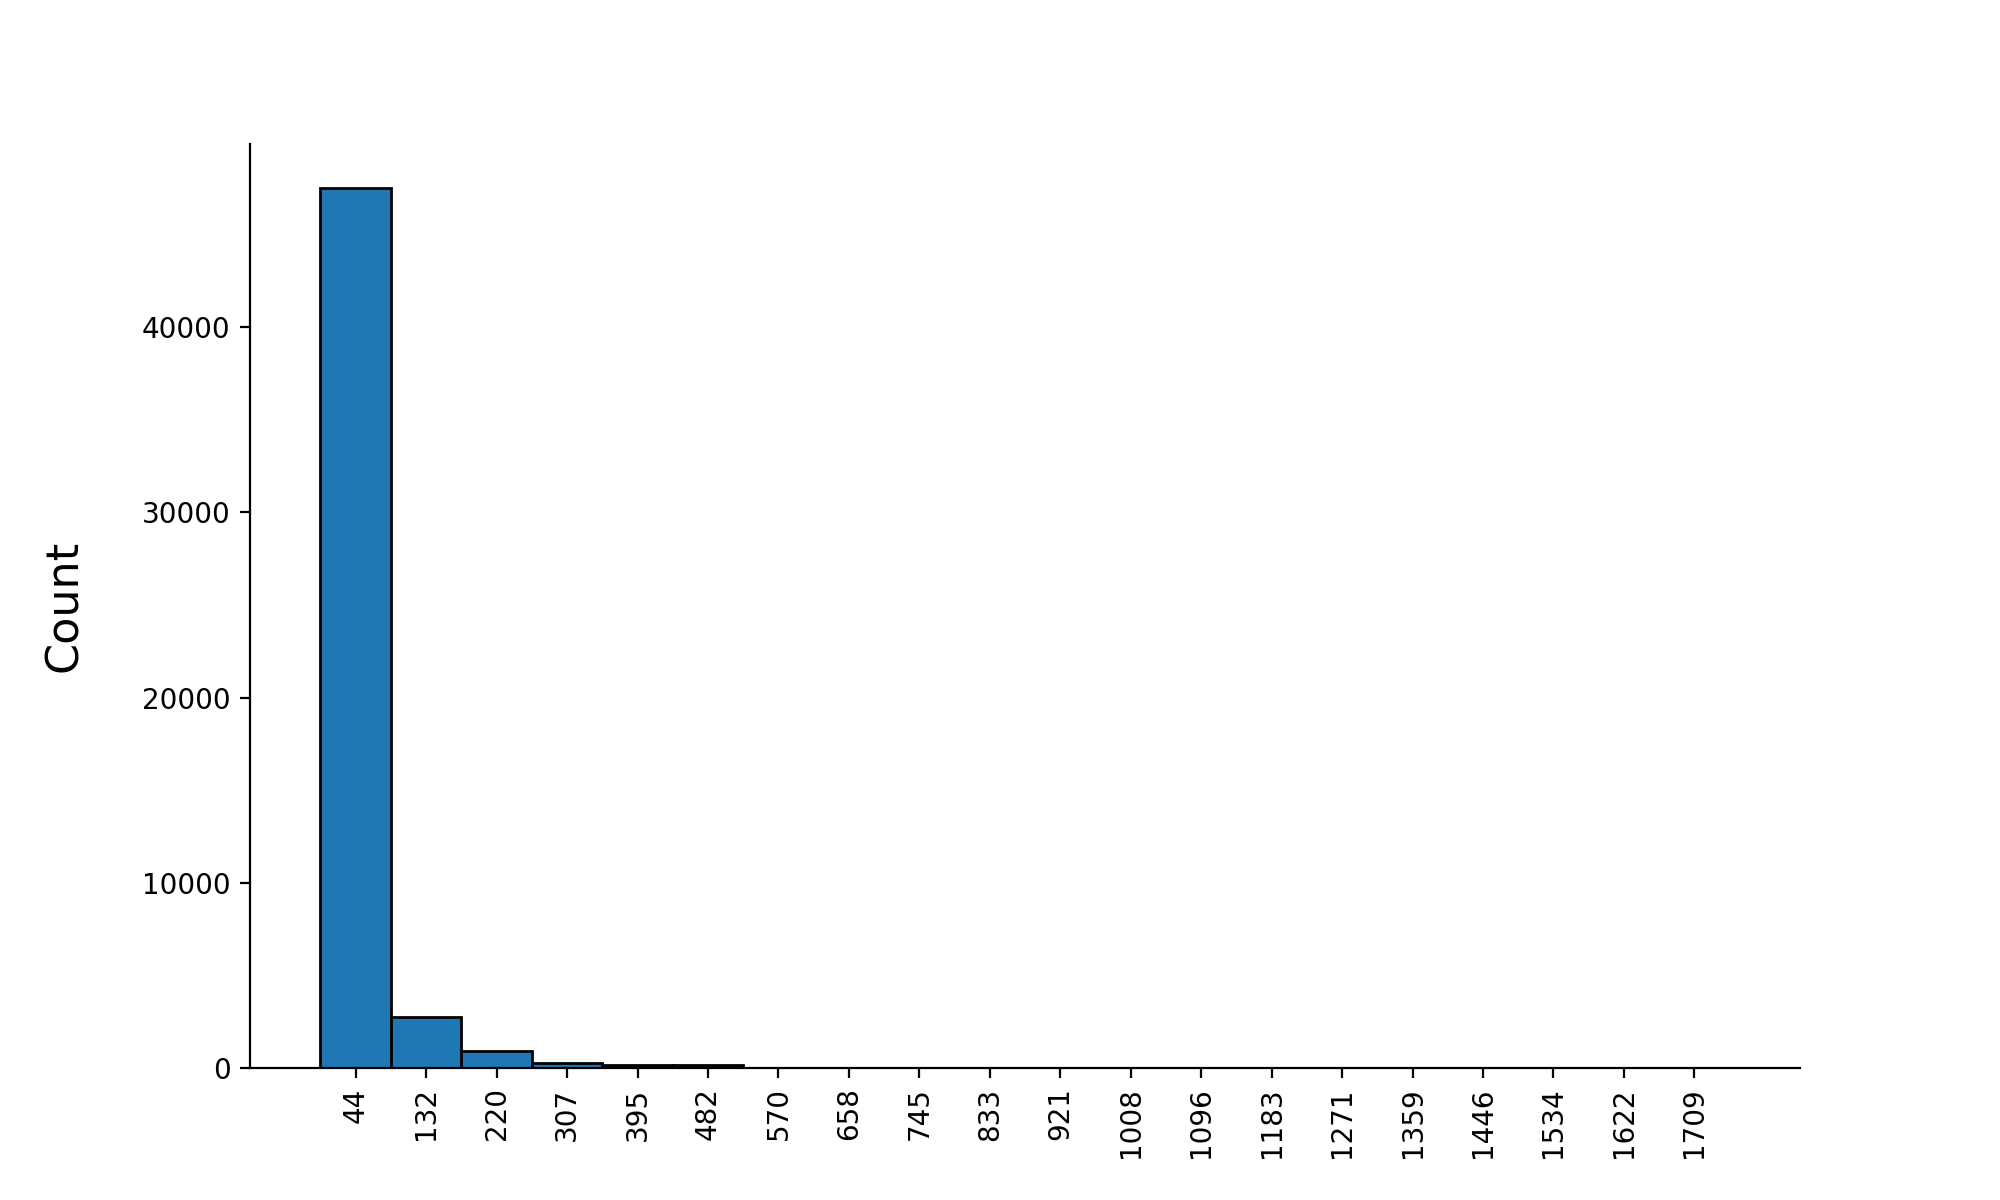

In [22]:
n_bins = 20
hist_of_numerical_feature(data_target_revenue, 'Total_revenue_at_day', n_bins)

<ipython-input-6-207e611714e3>:4: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


<IPython.core.display.Javascript object>


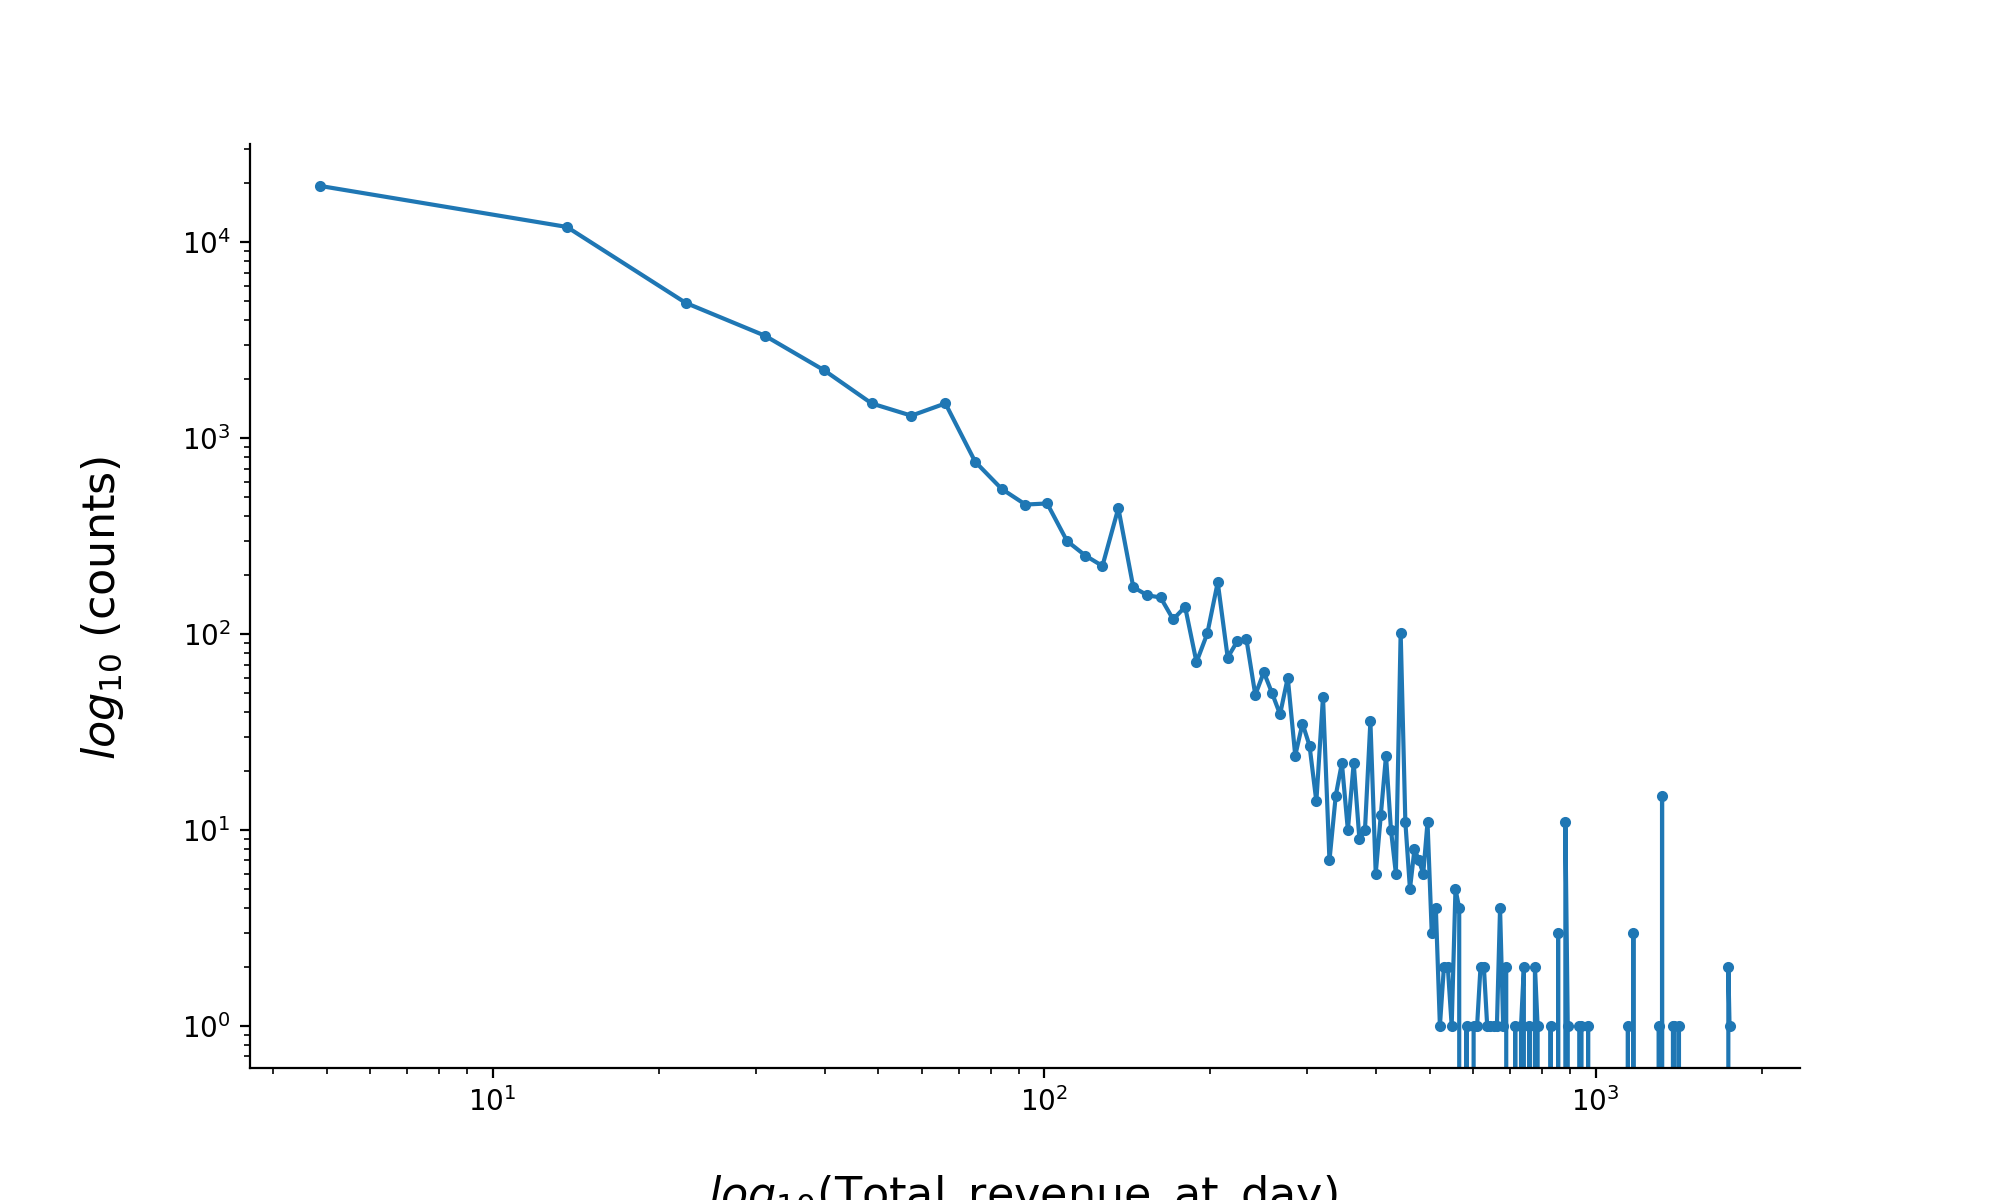

In [23]:
n_bins = 200
plot_loglog_scale(data_target_revenue, 'Total_revenue_at_day', n_bins)

The distribution of the revenue seems power-law even from a day of data. 

<IPython.core.display.Javascript object>


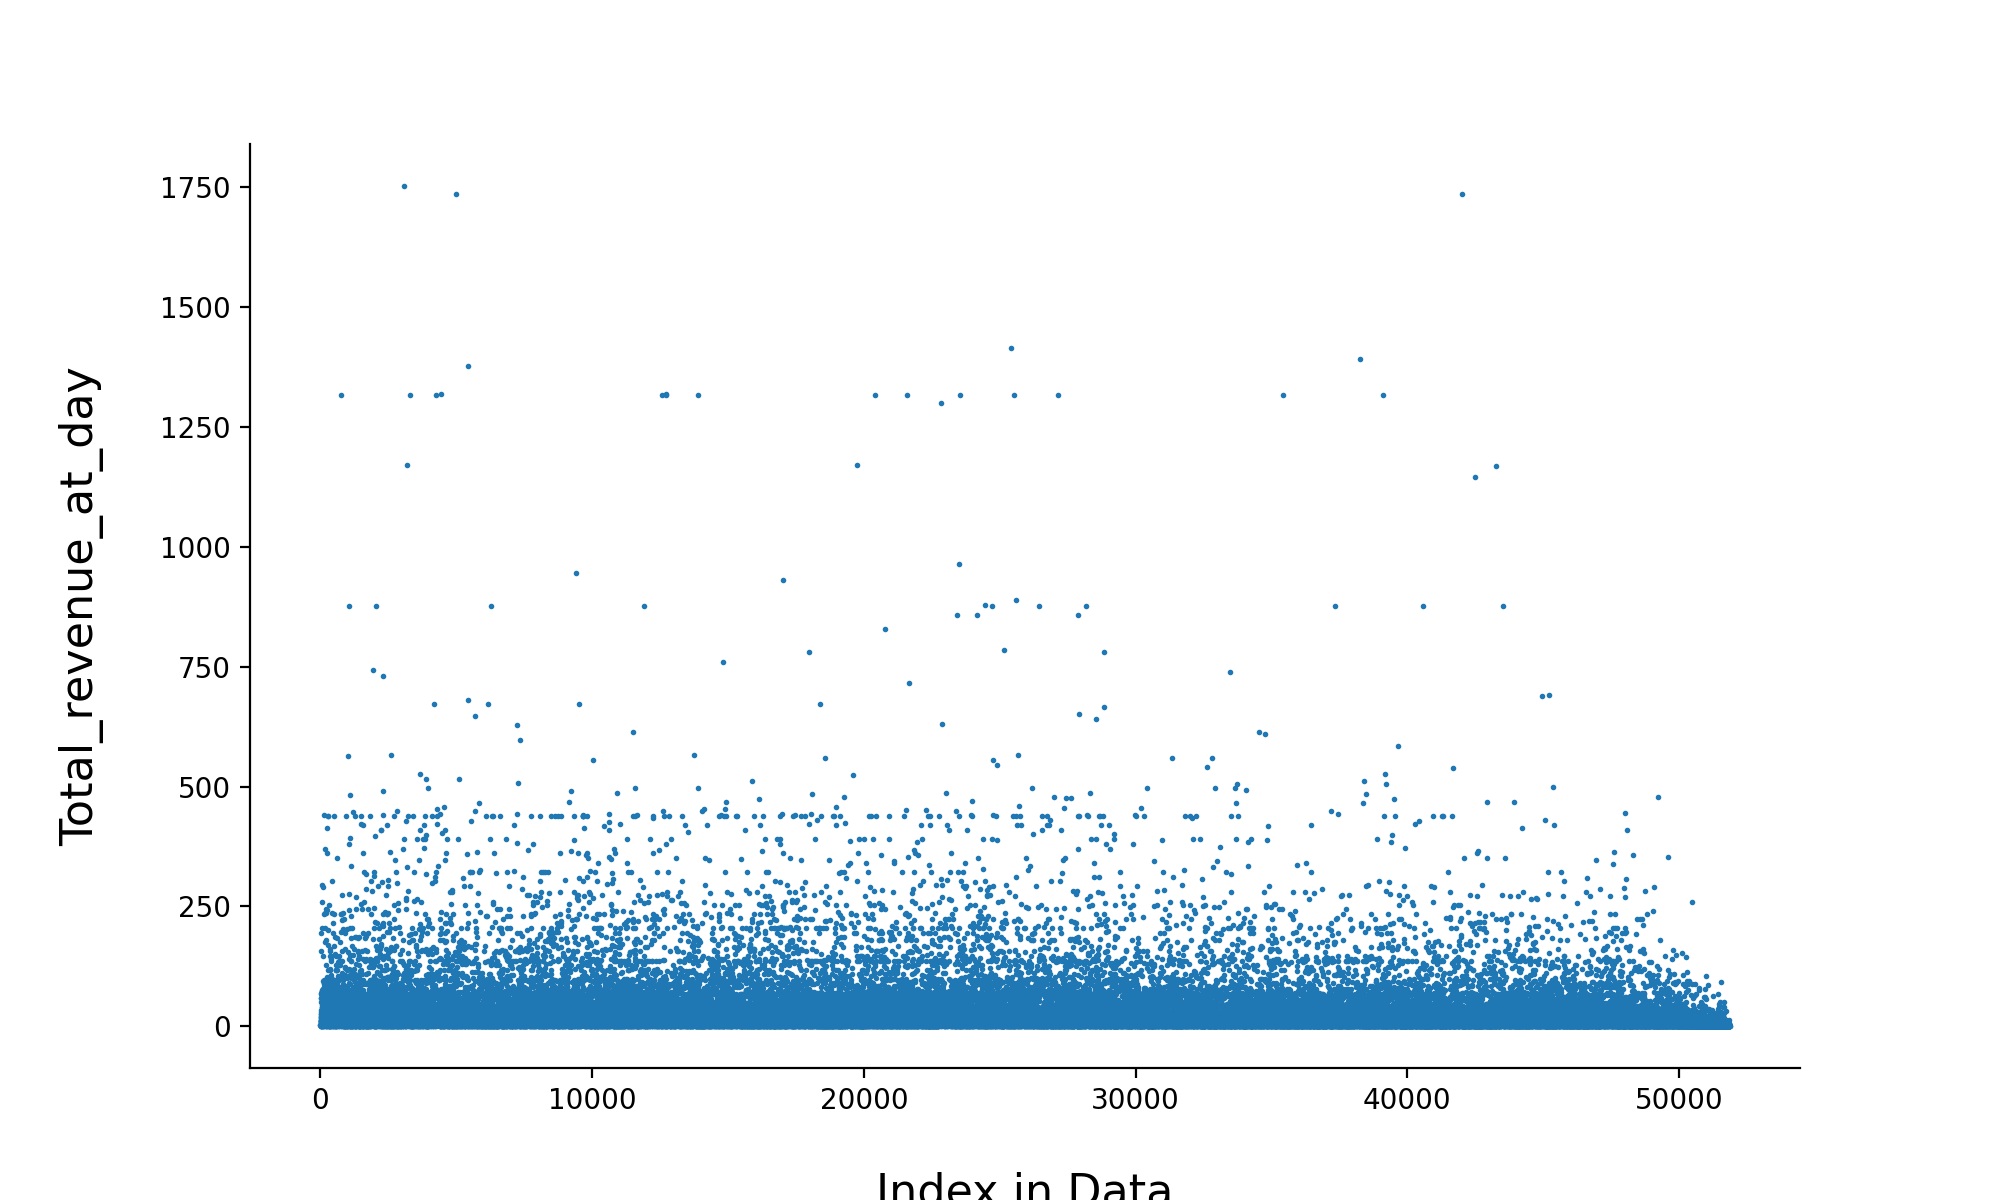


The lowest user id is: 600

and the highest user id is: 1004641327


In [24]:
marker_size = 2
plot_data_by_index(data_target_revenue, 'Total_revenue_at_day', marker_size)

print("\nThe lowest user id is: {}".format(data_target_revenue["dim_user_gid"].iloc[0]))
print("\nand the highest user id is: {}".format(data_target_revenue["dim_user_gid"].iloc[-1]))

<IPython.core.display.Javascript object>


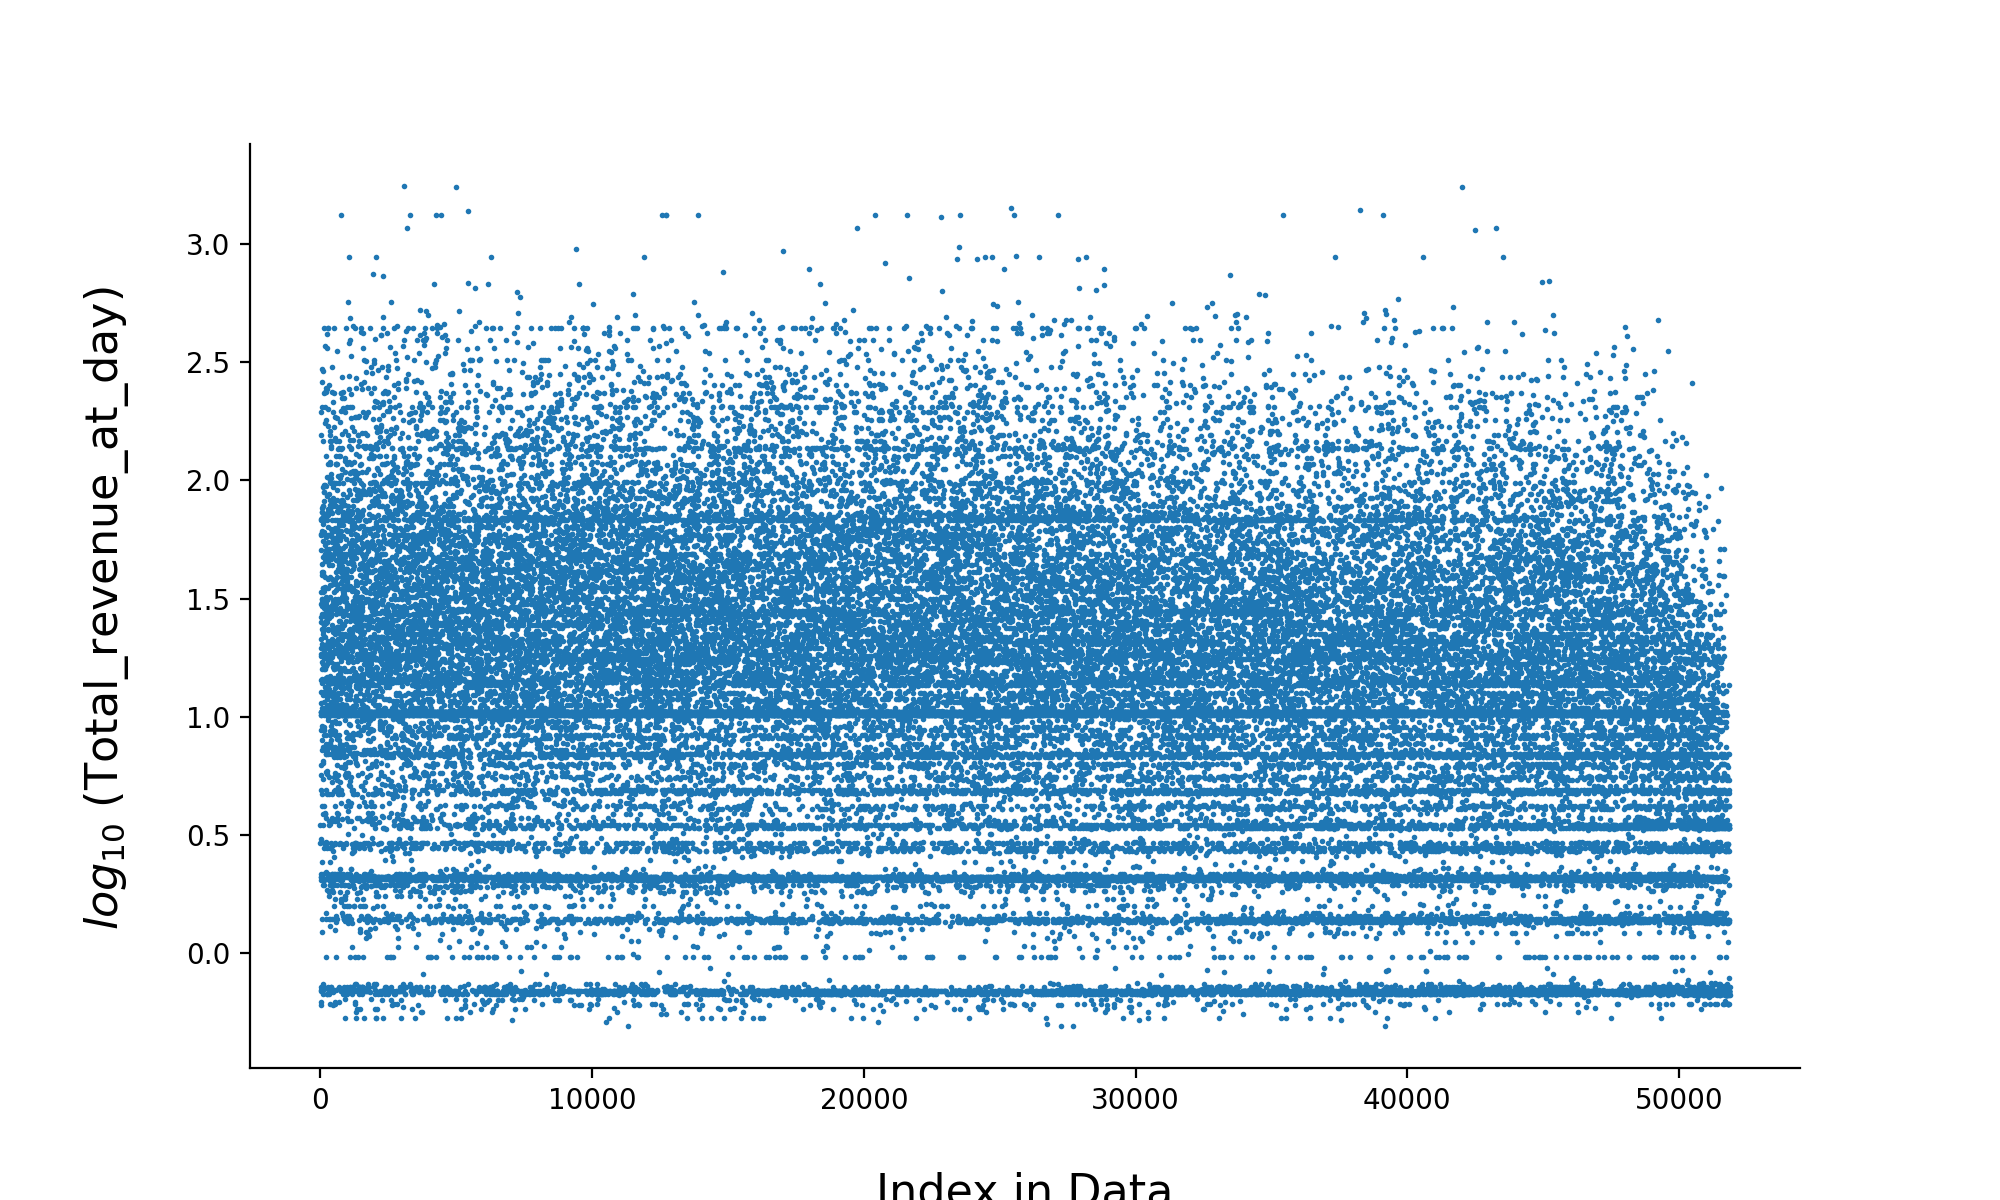

In [25]:
# And when the revenue is in log scale
plt.figure(figsize=(10,6))
plt.plot(range(data_target_revenue["dim_user_gid"].shape[0]), np.log10(data_target_revenue["Total_revenue_at_day"]), '.', markersize = marker_size)
plt.xlabel('Index in Data', labelpad=20, size=16)
plt.ylabel('$log_{10}$ (Total_revenue_at_day) ', labelpad=20, size=16)
sb.despine(top=True, right=True, left=False, bottom=False)

plt.show()

<IPython.core.display.Javascript object>


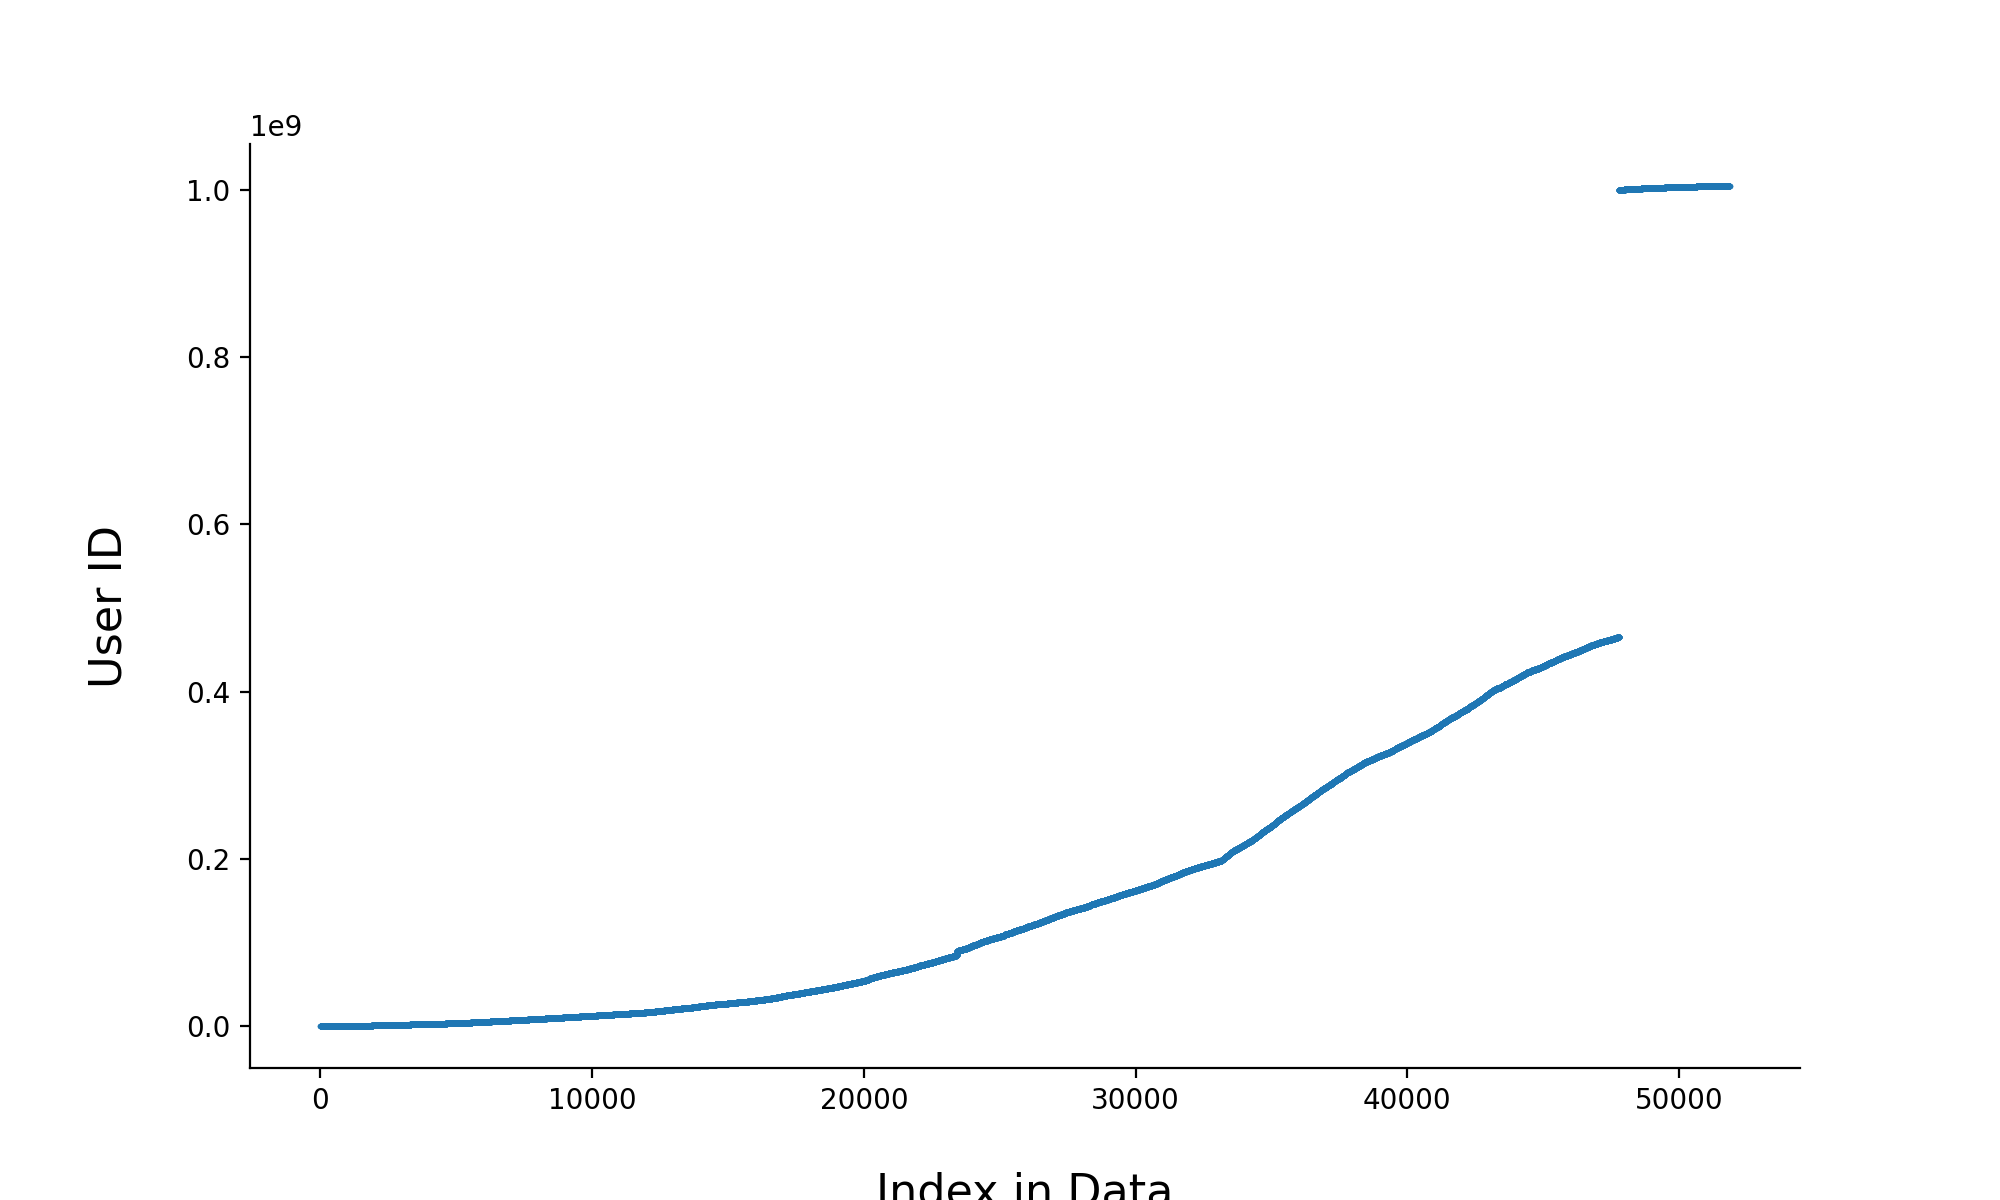

In [26]:
plt.figure(figsize=(10,6))
plt.plot(range(data_target_revenue["dim_user_gid"].shape[0]), data_target_revenue["dim_user_gid"], '.', markersize = marker_size)
plt.xlabel('Index in Data', labelpad=20, size=16)
plt.ylabel("User ID", labelpad=20, size=16)
sb.despine(top=True, right=True, left=False, bottom=False)

plt.show()

An initial analysis (part 1) suggests that the revenue depends on the seniority of the users. Here we see that although there exist a wide range of users IDs, which suggest a spread in seniority, the daily revenue seems almost independent of that (see figure in previous cell). Only the right most group of users with very high index numbers have lower average revenue. 

[back to top](#back_to_top)  <a id='kmeans'></a>

# K - Means 

In [65]:
# For random choice:  
randomly_choose = True
num_of_features = 3   # default is 3 to allow for visualization of the clustering results.
chosen_features = []

# # Or, provide a list, like: 
# randomly_choose = False
# chosen_features = ['level', 'Lifetime_Revenue_Net', 'credits_balance_EOD']

print_to_screen = True

sliced_data_for_clustering = slicing_df_for_clustering(data_for_clustering,  
                                                       numerical_columns,
                                                       randomly_choose, 
                                                       chosen_features,
                                                       num_of_features,
                                                       print_to_screen)

The chosen features are: ['coins_balance_EOD', 'Last_90D_Revenue_Net', 'number_of_bingo_rounds']

The data frame for the clustering has the following shape:
(4985297, 4)

A quick view of it:

       dim_user_gid  coins_balance_EOD  Last_90D_Revenue_Net  \
23899           261           989739.0                 0.000   
40151           288           129887.0                 0.000   
40152           312           485502.0                 0.000   
40153           376          2863137.0                10.493   
68592           381          1277645.0                10.493   
80781           388             4238.0                 0.000   
48277           391             4128.0                 0.000   
3584            427             9904.0                 0.000   
48278           436           342700.0                 0.000   
68593           454            25913.0                 0.000   

       number_of_bingo_rounds  
23899                       0  
40151                       0  
40152  

In [66]:
log = True  # whether to log all or some of the features given
log_features = "all"  # or a list of the features to log transform

# For the clustering, the full data-set of millions may take a long time to cluster (at least now 
# at the development phase). 
# So there are two options to slice the full data:
# 1. Choose which segment of the overall data and how many users to slice for the clustering 
num_of_points = 100000
segment = 1

# Or, choose a random fraction of the set: 
randomly_choose = True  # to choose the subset of users randomly.
by_fraction = True
fraction = 0.2
 
print_to_screen = True

In [67]:
X = create_df_for_kmeans(sliced_data_for_clustering, 
                         log,
                         log_features,
                         num_of_points, 
                         segment,
                         fraction,
                         randomly_choose, 
                         by_fraction, 
                         print_to_screen)

X.head(10)


No **nan** values in the data frame for clustering after the log transform. Please continue.

The shape of the data frame used for the clustering is:
(997059, 4)

The types of the columns are:
dim_user_gid                int64
coins_balance_EOD         float64
Last_90D_Revenue_Net      float64
number_of_bingo_rounds    float64
dtype: object


,dim_user_gid,coins_balance_EOD,Last_90D_Revenue_Net,number_of_bingo_rounds
3712593,454679113,3.814114,-2.0,-2.0
2764666,448301863,3.698970,-2.0,-2.0
4013591,456253507,3.776846,-2.0,-2.0
2334079,434878474,3.698970,-2.0,-2.0
3333026,451835641,3.762078,-2.0,-2.0
1515191,334817575,4.351506,-2.0,-2.0
4362381,458846569,3.929061,-2.0,-2.0
860942,177151990,5.416645,-2.0,-2.0
301693,28941587,6.559374,-2.0,-2.0
3347089,452051401,3.875756,-2.0,-2.0


In [32]:
# One possible choice of parameters:
# kmeans_kwargs = {
#                 "init": "random",
#                 "n_init": 10,
#                 "random_state": 42,
#                 }

In [68]:
kmeans_kwargs = {
                "init": "k-means++",
                "n_init": 50,
                "max_iter": 500,
                "random_state": 42,
                }

## For testing the goodness of the K-means

The next few cells deals with trying to estimate what is the best number of cluster for a given data set. 

In [67]:
sse = []
silhouette_coefficients = []

# A flag for whether to calculate the silhouette, as it takes quite some time for large data set.
calc_silhouette = False

for k in range(1, 11):
    print(k)
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X.drop(columns = ['dim_user_gid']))
    sse.append(kmeans.inertia_)
    
    if k > 1 and calc_silhouette:
        score = silhouette_score(X.drop(columns = ['dim_user_gid']), kmeans.labels_)
        silhouette_coefficients.append(score)

1
2
3
4
5
6
7
8
9
10


<IPython.core.display.Javascript object>


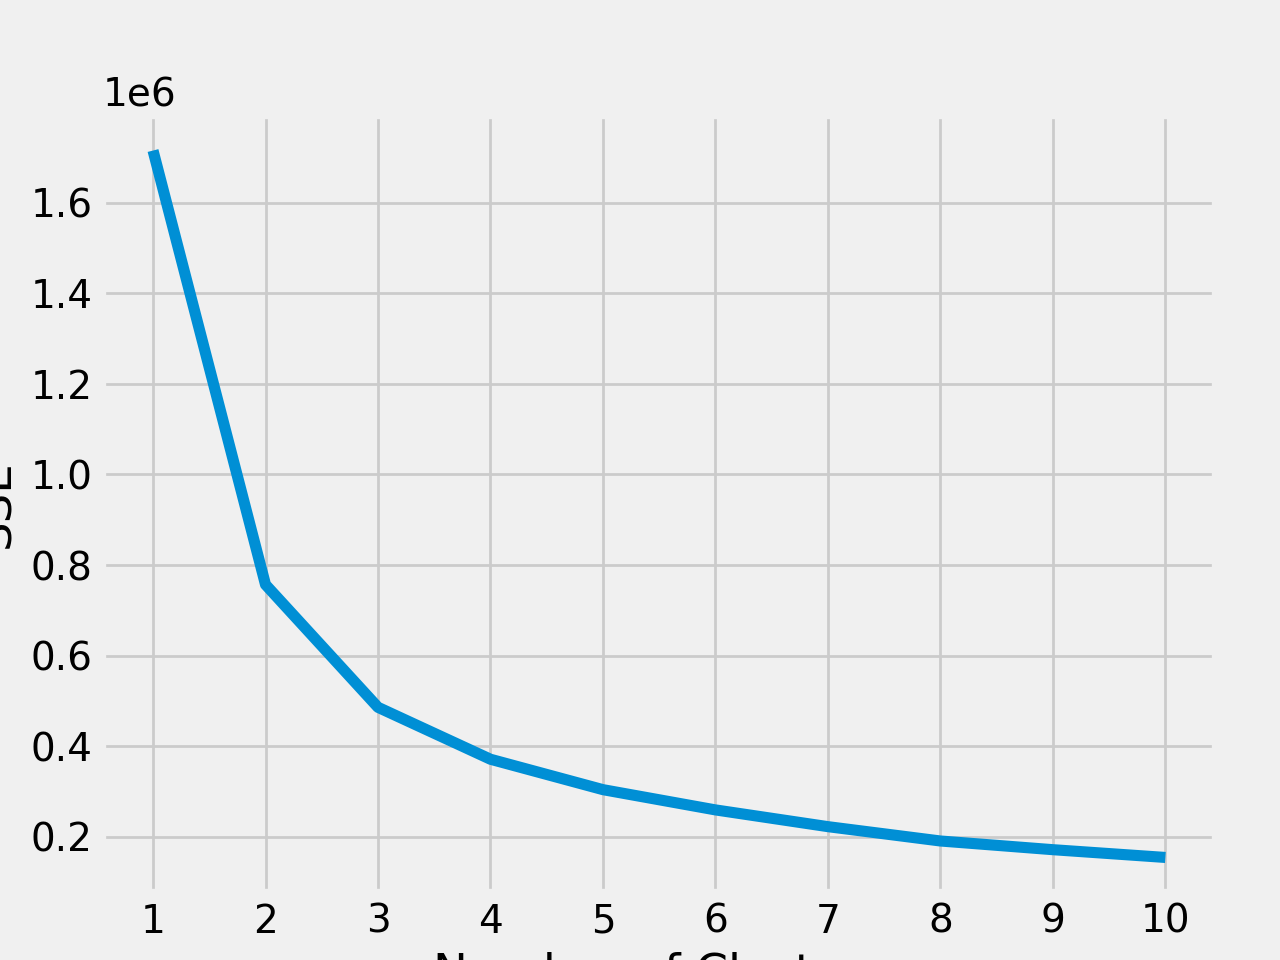

In [68]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [69]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
print("The preferred number of clusters is: {}.".format(kl.elbow))

The preferred number of clusters is: 3.


In [70]:
if calc_silhouette:
    plt.style.use("fivethirtyeight")
    plt.plot(range(2, 5), silhouette_coefficients)
    plt.xticks(range(2, 5))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()
else: 
    print("The Silhouette of this data set was *not* estimated.")

The Silhouette of this data set was *not* estimated.


### Now, back to the Kmeans -> choosing a number of cluster and get the results 

The number of cluster could be chosen by the output of the analysis above (knee location or from the Silhouette analysis), or by some arbitraray choice. 

In [34]:
knee_locator = False

In [69]:
# Create cluster feature

if knee_locator:
    num_of_clusters = kl.elbow
else:
    num_of_clusters = 6  # any number of choice, or from the silhouette analysis. 

In [70]:
# Running the K-means and adding the cluster column to the data-frame: 

start_time = time.time()
kmeans = KMeans(n_clusters=num_of_clusters, **kmeans_kwargs)
X["Cluster"] = kmeans.fit_predict(X.drop(columns = ['dim_user_gid']))
X["Cluster"] = X["Cluster"].astype("category")
end_time = time.time()

print("The Kmeans calculation for {} dimensions and {} rows was:\n{}sec".format(X.shape[1] - 2, X.shape[0], end_time - start_time))

X.head()

The Kmeans calculation for 3 dimensions and 997059 rows was:
23.202643871307373sec


,dim_user_gid,coins_balance_EOD,Last_90D_Revenue_Net,number_of_bingo_rounds,Cluster
3712593,454679113,3.814114,-2.0,-2.0,0
2764666,448301863,3.698970,-2.0,-2.0,0
4013591,456253507,3.776846,-2.0,-2.0,0
2334079,434878474,3.698970,-2.0,-2.0,0
3333026,451835641,3.762078,-2.0,-2.0,0


2-d sliced scatter plots of the clusters. If there were three features, then there are three such plots: 

In [74]:
# sb.relplot(
#     x=X.columns[1], y=X.columns[2], hue="Cluster", data=X, height=6)

# plt.show()

In [77]:
# sb.relplot(
#     x=X.columns[1], y=X.columns[3], hue="Cluster", data=X, height=6)

# plt.show()

In [76]:
# sb.relplot(
#     x=X.columns[2], y=X.columns[3], hue="Cluster", data=X, height=6)

# plt.show()

For the three features case, this is the full 3-d scatter plot with the different clusters: A full 

In [78]:
# sb.set(style = "darkgrid")

# fig = plt.figure(figsize = (12, 10))
# ax = Axes3D(fig)
# ax = fig.add_subplot(111, projection = '3d')

# x = X.iloc[:, [1]]
# y = X.iloc[:, [2]]
# z = X.iloc[:, [3]]

# ax.set_xlabel(X.columns[1])
# ax.set_ylabel(X.columns[2])
# ax.set_zlabel(X.columns[3])

# ax.scatter(x, y, z, c = X['Cluster'])

# plt.show()

In [71]:
# Inner-merge of the users in data that was clustered and the users in the target data:
X_merged_with_target = find_users_in_both_data_and_target_frames(X, data_target_revenue)


A short summary:
The target frame was merged with the historical data frame, and it includes *only* users that appears in both.
There are 1208 different rows, and 7 different columns.
There are 0 *nan* values at the dim_user_gid column.
There are 1208 unique values at the dim_user_gid column.

Keeping only the last entry of each duplicate.
The end data frame has 1208 rows.
It was sorted by the dim_user_gid column.



In [72]:
X_merged_with_target.head()

,dim_user_gid,coins_balance_EOD,Last_90D_Revenue_Net,number_of_bingo_rounds,Cluster,Total_revenue_at_day,num_purchase_events_of_user
3598,3401,6.907155,-2.000000,-2.00000,3,10.1933,1
7750,25672,5.246540,-2.000000,0.69897,2,259.3015,5
44343,32583,5.629707,-0.159267,-2.00000,4,7.3262,2
32224,47299,5.562961,-2.000000,-2.00000,3,10.4930,1
24244,93506,6.395467,2.347303,0.00000,1,2.7860,2


<IPython.core.display.Javascript object>


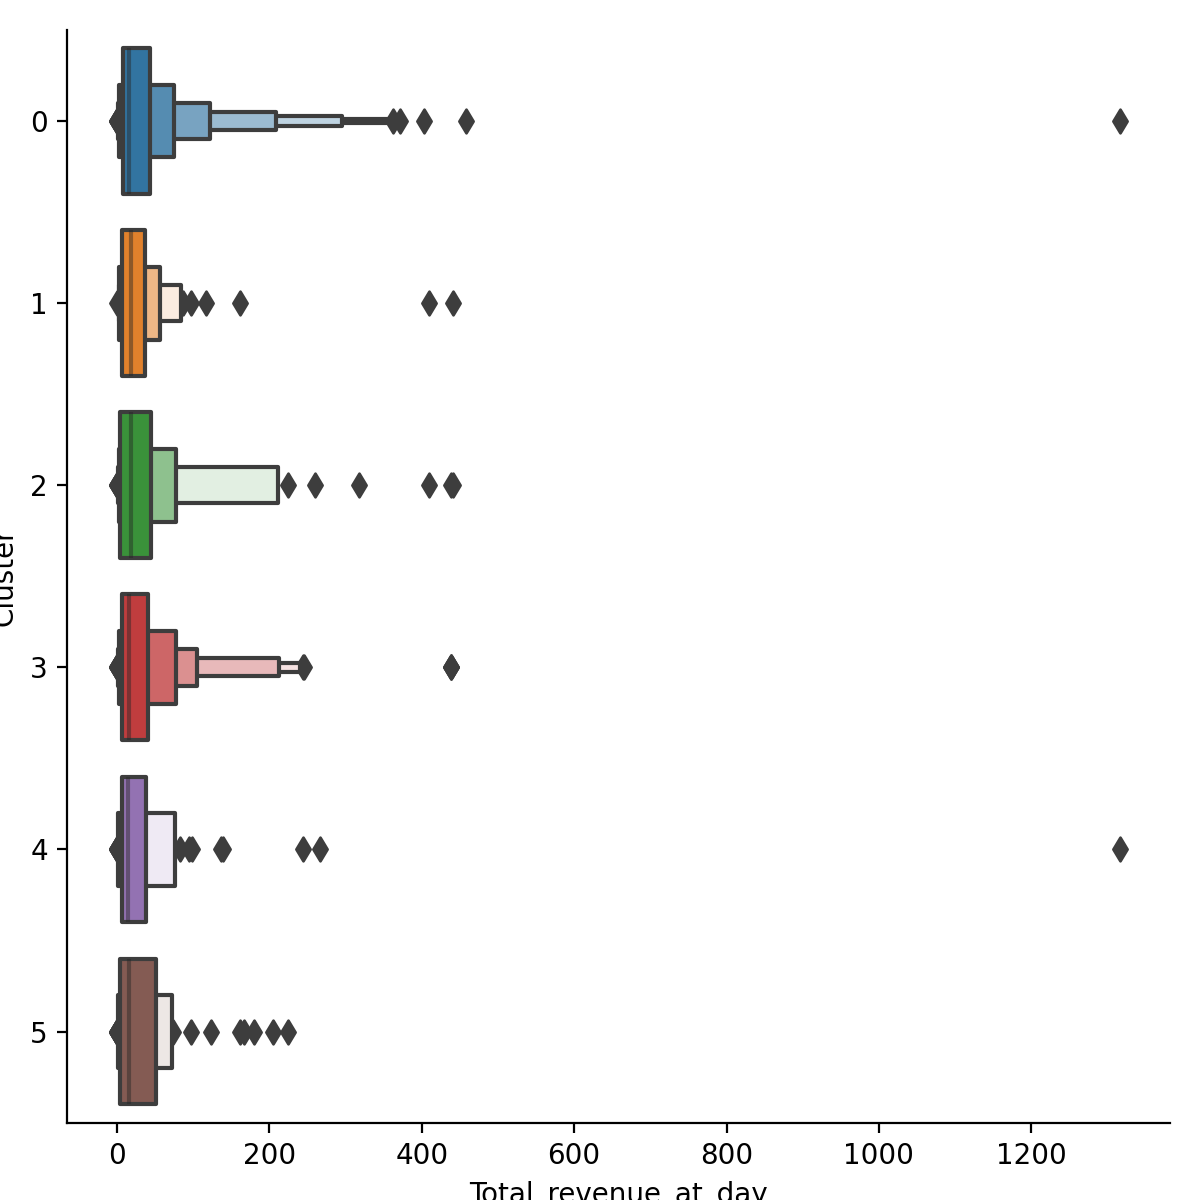

In [73]:
# Plotting the spread of the target values in each of the clusters:
sb.catplot(x="Total_revenue_at_day", y="Cluster", data=X_merged_with_target, kind="boxen", height=6)
plt.show()

## Homogeneity 

#### By Percentile 

In [74]:
low_percentile = 10
top_percentile = 90

In [75]:
print("The {}th percential of the target is: {:.3f}".format(low_percentile, np.percentile(X_merged_with_target["Total_revenue_at_day"], low_percentile)))
print("The {}th percential of the target is: {:.3f}".format(top_percentile, np.percentile(X_merged_with_target["Total_revenue_at_day"], top_percentile)))

The 10th percential of the target is: 2.091
The 90th percential of the target is: 88.784


In [76]:
look_at_cluster = 5

In [77]:
print(len(X_merged_with_target[X_merged_with_target['Cluster'] == look_at_cluster]['Total_revenue_at_day']))
np.percentile(X_merged_with_target[X_merged_with_target['Cluster'] == look_at_cluster]['Total_revenue_at_day'], low_percentile)

61


1.393

In [78]:
print(len(X_merged_with_target[X_merged_with_target['Cluster'] == look_at_cluster]['Total_revenue_at_day']))
np.percentile(X_merged_with_target[X_merged_with_target['Cluster'] == look_at_cluster]['Total_revenue_at_day'], top_percentile)

61


97.4903

In [115]:
target_percentile_diff = np.percentile(X_merged_with_target["Total_revenue_at_day"], top_percentile) - np.percentile(X_merged_with_target["Total_revenue_at_day"], low_percentile)

homogeneity = []
weighted_homogeneity = []

for cluster in range(num_of_clusters):
    cluster_size = len(X_merged_with_target[X_merged_with_target['Cluster'] == cluster]['Total_revenue_at_day'])
    cluster_percentile_diff = np.percentile(X_merged_with_target[X_merged_with_target['Cluster'] == cluster]['Total_revenue_at_day'], top_percentile) - \
                                np.percentile(X_merged_with_target[X_merged_with_target['Cluster'] == cluster]['Total_revenue_at_day'], low_percentile)
    homogeneity.append((1 - cluster_percentile_diff/target_percentile_diff))
    weighted_homogeneity.append(homogeneity[-1]*cluster_size)
    
print("Homogeneity by Percentile per cluster:\n{}".format(homogeneity))
print()
print("Average Homogeneity by Percentile:\n{}".format(np.mean(homogeneity)))
print()
print("Weighted average of homogeneity by Percentile:\n{}".format(sum(weighted_homogeneity)/X_merged_with_target.shape[0]))

Homogeneity by Percentile per cluster:
[0.02347990365065533, 0.2869631939700673, -0.27983181083194153, -0.003185383432961153, -0.051104554631143495, -0.10847998324198804]

Average Homogeneity by Percentile:
-0.022026439086218597

Weighted average of homogeneity by Percentile:
0.004269001931125824


#### By Max-Min

In [80]:
print("The min value of the target is: {:.3f}".format(np.min(X_merged_with_target["Total_revenue_at_day"])))
print("The max value of the target is: {:.3f}".format(np.max(X_merged_with_target["Total_revenue_at_day"])))

The min value of the target is: 0.533
The max value of the target is: 1316.221


In [81]:
look_at_cluster = 5

In [82]:
print("Size of cluster {} in merged data is: {}".format(look_at_cluster, len(X_merged_with_target[X_merged_with_target['Cluster'] == look_at_cluster]['Total_revenue_at_day'])))
print("Min value of the target within this cluster is: {}".format(np.min(X_merged_with_target[X_merged_with_target['Cluster'] == look_at_cluster]['Total_revenue_at_day'])))
print("Max value of the target within this cluster is: {}".format(np.max(X_merged_with_target[X_merged_with_target['Cluster'] == look_at_cluster]['Total_revenue_at_day'])))

Size of cluster 5 in merged data is: 61
Min value of the target within this cluster is: 0.533
Max value of the target within this cluster is: 224.2403


In [116]:
target_min_max_diff = np.max(X_merged_with_target["Total_revenue_at_day"]) - np.min(X_merged_with_target["Total_revenue_at_day"])

homogeneity = []
weighted_homogeneity = []

for cluster in range(num_of_clusters):
    cluster_size = len(X_merged_with_target[X_merged_with_target['Cluster'] == cluster]['Total_revenue_at_day'])
    cluster_min_max_diff = np.max(X_merged_with_target[X_merged_with_target['Cluster'] == cluster]['Total_revenue_at_day']) - \
                                np.min(X_merged_with_target[X_merged_with_target['Cluster'] == cluster]['Total_revenue_at_day'])
    homogeneity.append((1 - cluster_min_max_diff/target_min_max_diff))
    weighted_homogeneity.append(homogeneity[-1]*cluster_size)

print("Homogeneity by MinMax per cluster:\n{}".format(homogeneity))
print()
print("Average Homogeneity by MinMax:\n{}".format(np.mean(homogeneity)))
print()
print("Weighted average of homogeneity by MinMax:\n{}".format(sum(weighted_homogeneity)/X_merged_with_target.shape[0]))

Homogeneity by MinMax per cluster:
[2.2801760204860244e-05, 0.6656027618708054, 0.6655228036983543, 0.6669367408486466, 0.0, 0.829969326312114]

Average Homogeneity by MinMax:
0.4713424057483542

[0.014319505408652233, 56.576234759018455, 55.2383927069634, 192.0777813644102, 0.0, 50.62812890503895]
Weighted average of homogeneity by MinMax:
0.29348912023248314


#### By distance

In [87]:
def calculate_squared_distances(data):
    
    mean_value = np.mean(data)
    distances = []
    for elem in data:
        distances.append((elem - mean_value)**2)
        
    mean_distances = sum(distances)/len(data)
    
    return mean_distances

In [85]:
mean_distances_target = calculate_squared_distances(X_merged_with_target["Total_revenue_at_day"])
print(mean_distances_target)

6582.203761701844


In [118]:
homogeneity = []
weighted_homogeneity = []

for cluster in range(num_of_clusters):
    cluster_size = len(X_merged_with_target[X_merged_with_target['Cluster'] == cluster]['Total_revenue_at_day'])
    mean_distances_cluster = calculate_squared_distances(X_merged_with_target[X_merged_with_target['Cluster'] == cluster]['Total_revenue_at_day'])
    homogeneity.append((1 - mean_distances_cluster/mean_distances_target))
    weighted_homogeneity.append(homogeneity[-1]*cluster_size)

print("Homogeneity by distances per cluster:\n{}".format(homogeneity))
print()
print("Average Homogeneity by distances:\n{}".format(np.mean(homogeneity)))
print()
print("Weighted average of homogeneity by distances:\n{}".format(sum(weighted_homogeneity)/X_merged_with_target.shape[0]))

Homogeneity by distances per cluster:
[0.06581538890274719, 0.3269779104142567, -0.25875639721560595, 0.44380871106432795, -3.293943900411776, 0.5892092083405127]

Average Homogeneity by distances:
-0.35448151315092286

Weighted average of homogeneity by distances:
0.0032190483581105906


## Examine significance of Homogeneity estimate 

In [53]:
def calc_target_splits(data, 
                       target_column, 
                       splits_by_column = "Cluster"): 
        
    shuffled_target = np.random.permutation(data[target_column])
    split_sizes = data[splits_by_column].value_counts().values
    splits_at = np.cumsum(split_sizes)
    splits = np.split(shuffled_target, splits_at)
    splits.pop(-1)
    
    return splits

In [123]:
def calc_homogeneity_by_percentile_for_splits(splits, 
                                              low_percentile, 
                                              top_percentile):
    
    splits_merged = [item for sublist in splits for item in sublist]
    overall_percentile_diff = np.percentile(splits_merged, top_percentile) - np.percentile(splits_merged, low_percentile)

    homogeneity = []
    weighted_homogeneity = []
    
    for split in splits:
        split_percentile_diff = np.percentile(split, top_percentile) - np.percentile(split, low_percentile)
        homogeneity.append((1 - split_percentile_diff/overall_percentile_diff))
        weighted_homogeneity.append(homogeneity[-1]*len(split))
    
    return np.mean(homogeneity), sum(weighted_homogeneity)/len(splits_merged)

In [127]:
def calc_homogeneity_by_MinMax_for_splits(splits):
    
    splits_merged = [item for sublist in splits for item in sublist]
    overall_min_max_diff = np.max(splits_merged) - np.min(splits_merged)

    homogeneity = []
    weighted_homogeneity = []

    for split in splits:
        split_min_max_diff = np.max(split) - np.min(split)
        homogeneity.append((1 - split_min_max_diff/overall_min_max_diff))
        weighted_homogeneity.append(homogeneity[-1]*len(split))

    return np.mean(homogeneity), sum(weighted_homogeneity)/len(splits_merged)

In [129]:
def calc_homogeneity_by_distances_for_splits(splits):
    
    splits_merged = [item for sublist in splits for item in sublist]
    mean_distances_overall = calculate_squared_distances(splits_merged)

    homogeneity = []
    weighted_homogeneity = []
    
    for split in splits:
        mean_distances_split = calculate_squared_distances(split)
        homogeneity.append((1 - mean_distances_split/mean_distances_overall)) 
        weighted_homogeneity.append(homogeneity[-1]*len(split))
        
    return np.mean(homogeneity), sum(weighted_homogeneity)/len(splits_merged)

In [88]:
target_column = "Total_revenue_at_day"

In [89]:
splits = calc_target_splits(X_merged_with_target, target_column)

In [124]:
# Doing bootstrapping for a given clustering parcelation. Splitting the data and then calculating the 
# average homogeneity for many times, to get the distribution of values. 

avg_homogeneity_random_sampling_from_target = []
avg_weighted_homogeneity_random_sampling_from_target = []

for k in range(10000):
    if k%2000 == 0:
        print(k)
    splits = calc_target_splits(X_merged_with_target, target_column)
    avg_homogeneity, avg_weighted_homogeneity = calc_homogeneity_by_percentile_for_splits(splits, low_percentile, top_percentile)
    avg_homogeneity_random_sampling_from_target.append(avg_homogeneity)
    avg_weighted_homogeneity_random_sampling_from_target.append(avg_weighted_homogeneity)
    
print()
print("The average homogeneity over the bootstrap samples: {:.5f}".format(np.mean(avg_homogeneity_random_sampling_from_target)))
print("The 0.025 percentile boundry is at: {:.5f}".format(np.percentile(avg_homogeneity_random_sampling_from_target, 2.5)))
print("The 0.975 percentile boundry is at: {:.5f}".format(np.percentile(avg_homogeneity_random_sampling_from_target, 97.5)))
print()
print("The average weighted homogeneity over the bootstrap samples: {:.5f}".format(np.mean(avg_weighted_homogeneity_random_sampling_from_target)))
print("The 0.025 percentile boundry is at: {:.5f}".format(np.percentile(avg_weighted_homogeneity_random_sampling_from_target, 2.5)))
print("The 0.975 percentile boundry is at: {:.5f}".format(np.percentile(avg_weighted_homogeneity_random_sampling_from_target, 97.5)))

0
2000
4000
6000
8000

The average homogeneity over the bootstrap samples: 0.00869
The 0.025 percentile boundry is at: -0.15147
The 0.975 percentile boundry is at: 0.12122

The average weighted homogeneity over the bootstrap samples: 0.00692
The 0.025 percentile boundry is at: -0.03567
The 0.975 percentile boundry is at: 0.04322


<IPython.core.display.Javascript object>


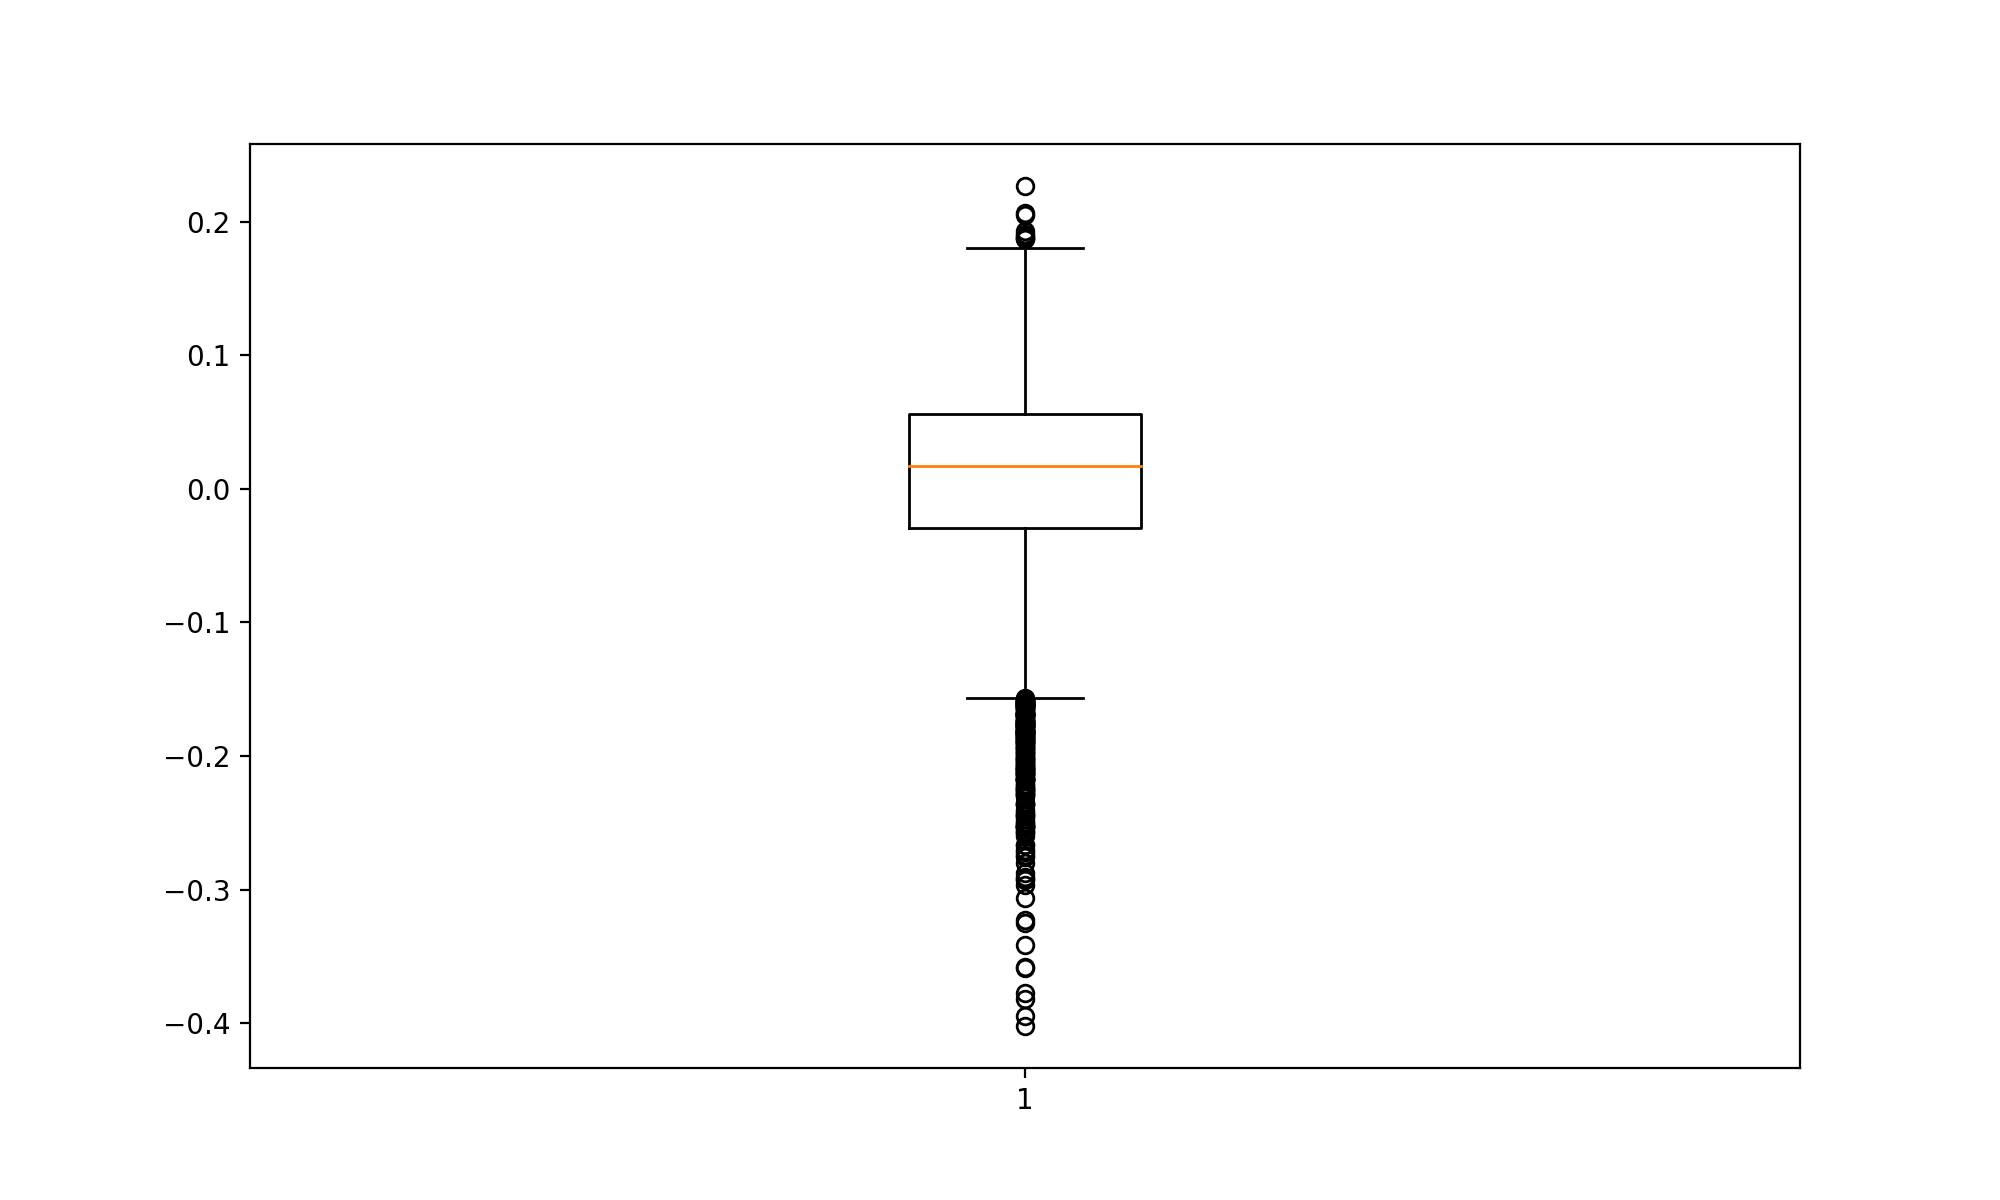

In [125]:
fig = plt.figure(figsize =(10, 6))
plt.boxplot(avg_homogeneity_random_sampling_from_target)
plt.show()

<IPython.core.display.Javascript object>


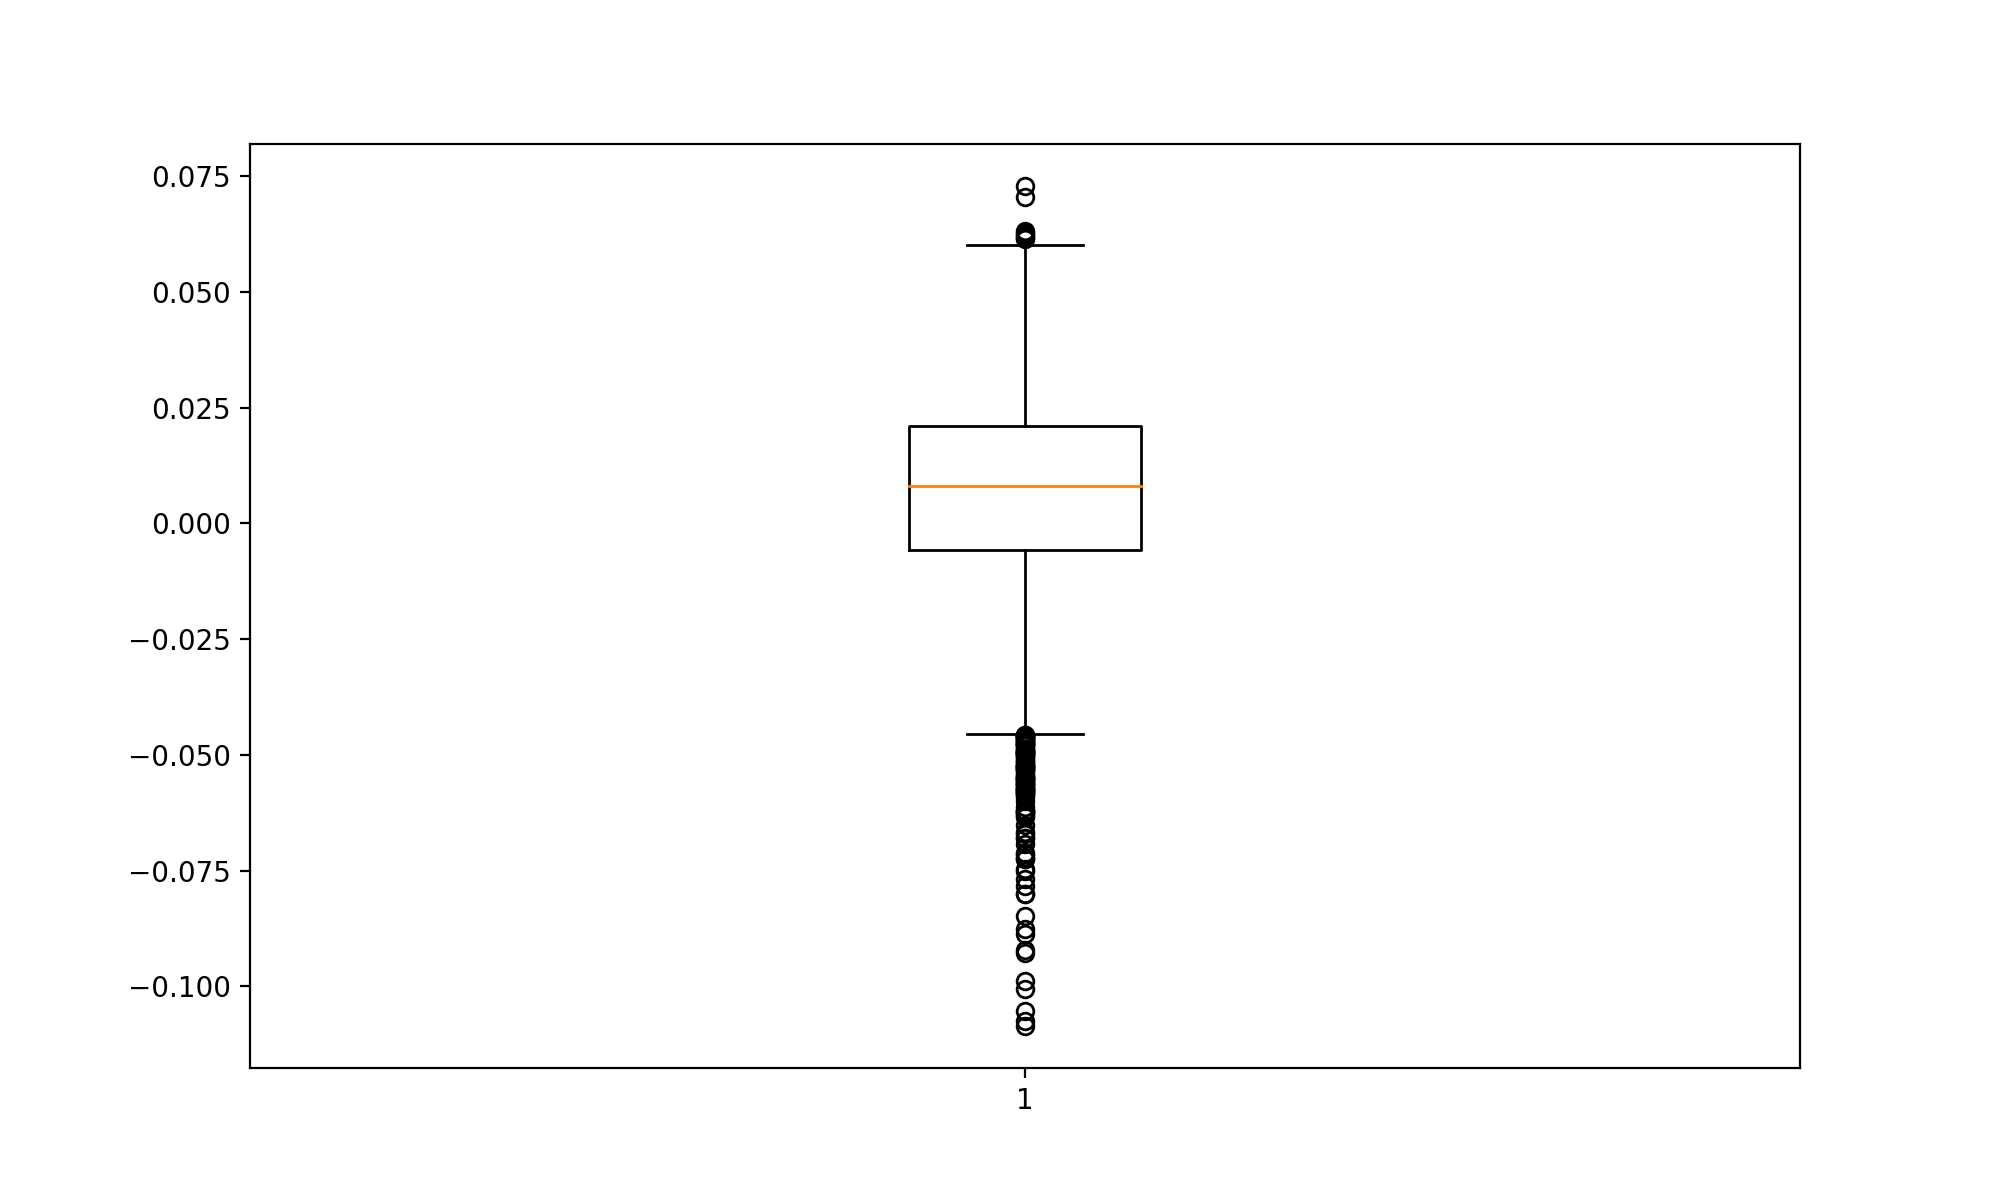

In [126]:
fig = plt.figure(figsize =(10, 6))
plt.boxplot(avg_weighted_homogeneity_random_sampling_from_target)
plt.show()

In [128]:
# Same for the MinMax approach: 

avg_homogeneity_random_sampling_from_target = []
avg_weighted_homogeneity_random_sampling_from_target = []

for k in range(10000):
    if k%2000 == 0:
        print(k)
    splits = calc_target_splits(X_merged_with_target, target_column)
    avg_homogeneity, avg_weighted_homogeneity = calc_homogeneity_by_MinMax_for_splits(splits)
    avg_homogeneity_random_sampling_from_target.append(avg_homogeneity)
    avg_weighted_homogeneity_random_sampling_from_target.append(avg_weighted_homogeneity)
    
print()
print("The average homogeneity over the bootstrap samples: {:.5f}".format(np.mean(avg_homogeneity_random_sampling_from_target)))
print("The 0.025 MinMax is at: {:.5f}".format(np.percentile(avg_homogeneity_random_sampling_from_target, 2.5)))
print("The 0.975 MinMax is at: {:.5f}".format(np.percentile(avg_homogeneity_random_sampling_from_target, 97.5)))
print()
print("The average weighted homogeneity over the bootstrap samples: {:.5f}".format(np.mean(avg_weighted_homogeneity_random_sampling_from_target)))
print("The 0.025 MinMax is at: {:.5f}".format(np.percentile(avg_weighted_homogeneity_random_sampling_from_target, 2.5)))
print("The 0.975 MinMax is at: {:.5f}".format(np.percentile(avg_weighted_homogeneity_random_sampling_from_target, 97.5)))

0
2000
4000
6000
8000

The average homogeneity over the bootstrap samples: 0.52378
The 0.025 MinMax is at: 0.44659
The 0.975 MinMax is at: 0.63477

The average weighted homogeneity over the bootstrap samples: 0.32874
The 0.025 MinMax is at: 0.16750
The 0.975 MinMax is at: 0.59514


<IPython.core.display.Javascript object>


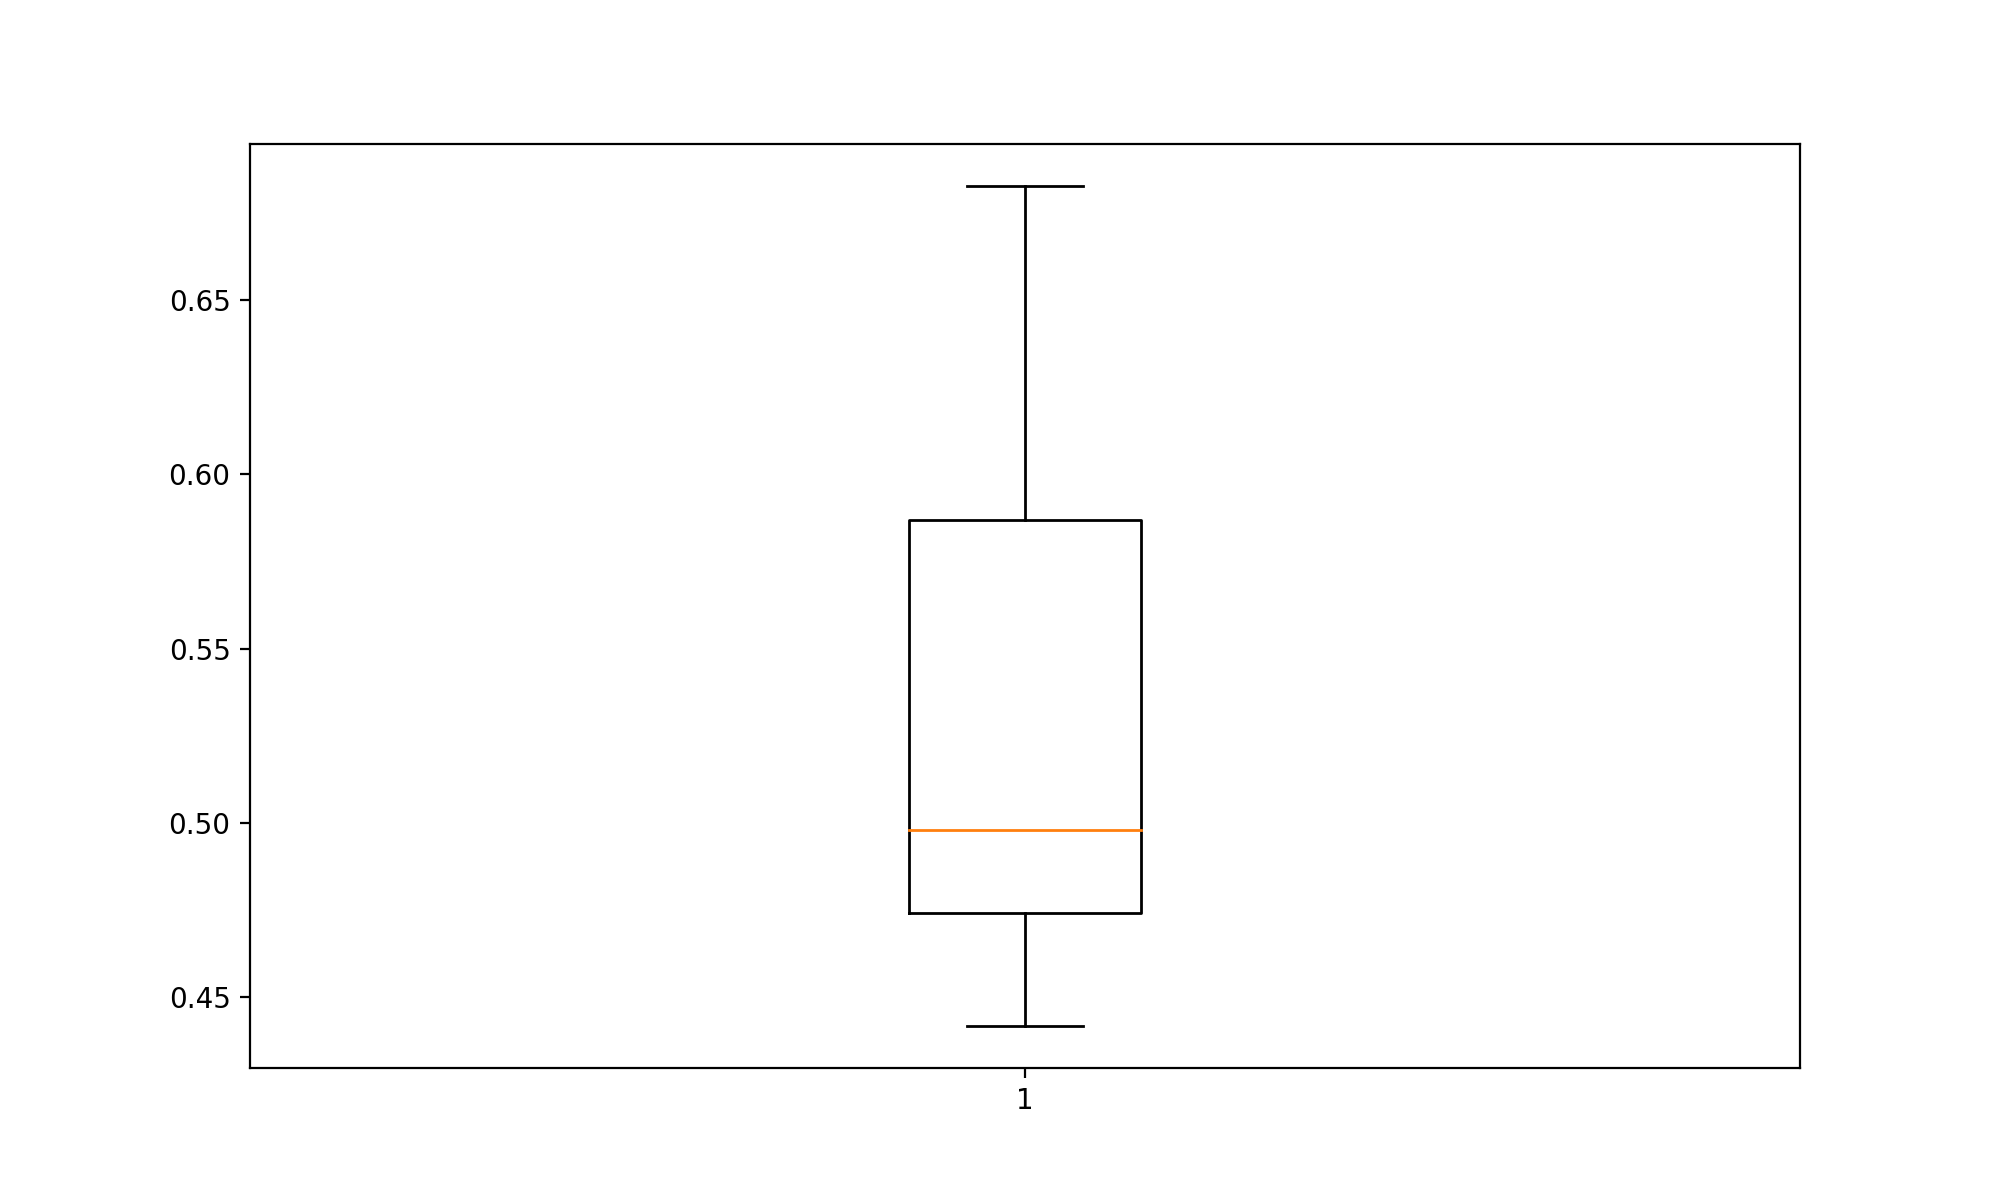

In [130]:
fig = plt.figure(figsize =(10, 6))
plt.boxplot(avg_homogeneity_random_sampling_from_target)
plt.show()

<IPython.core.display.Javascript object>


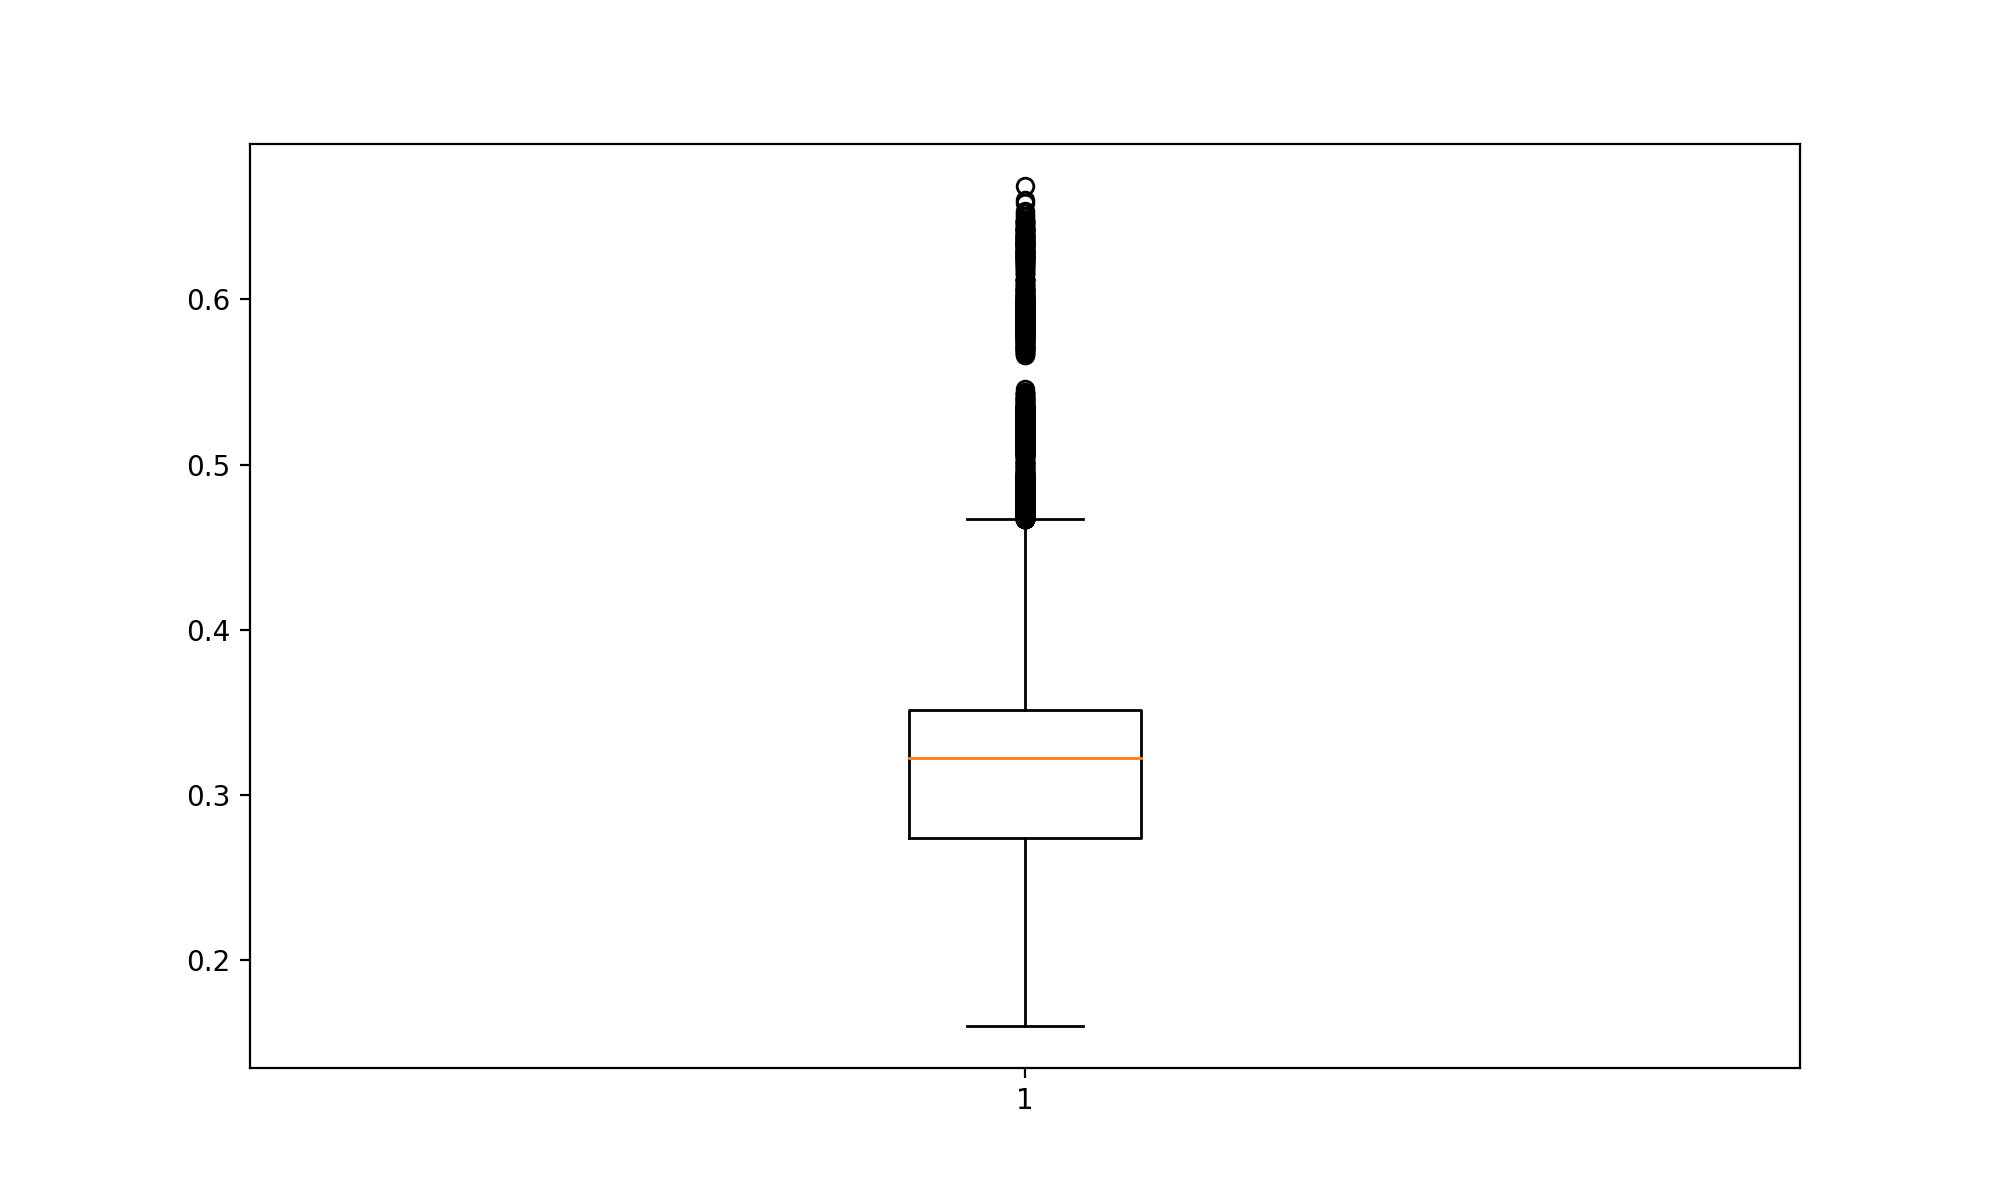

In [131]:
fig = plt.figure(figsize =(10, 6))
plt.boxplot(avg_weighted_homogeneity_random_sampling_from_target)
plt.show()

In [132]:
# Same for the distances approach: 

avg_homogeneity_random_sampling_from_target = []
avg_weighted_homogeneity_random_sampling_from_target = []

for k in range(10000):
    if k%2000 == 0:
        print(k)
    splits = calc_target_splits(X_merged_with_target, target_column)
    avg_homogeneity, avg_weighted_homogeneity = calc_homogeneity_by_distances_for_splits(splits)
    avg_homogeneity_random_sampling_from_target.append(avg_homogeneity)
    avg_weighted_homogeneity_random_sampling_from_target.append(avg_weighted_homogeneity)

print()
print("The average homogeneity over the bootstrap samples: {:.5f}".format(np.mean(avg_homogeneity_random_sampling_from_target)))
print("The 0.025 distances approach is at: {:.5f}".format(np.percentile(avg_homogeneity_random_sampling_from_target, 2.5)))
print("The 0.975 distances approach is at: {:.5f}".format(np.percentile(avg_homogeneity_random_sampling_from_target, 97.5)))
print()
print("The average weighted homogeneity over the bootstrap samples: {:.5f}".format(np.mean(avg_weighted_homogeneity_random_sampling_from_target)))
print("The 0.025 distances is at: {:.5f}".format(np.percentile(avg_weighted_homogeneity_random_sampling_from_target, 2.5)))
print("The 0.975 distances is at: {:.5f}".format(np.percentile(avg_weighted_homogeneity_random_sampling_from_target, 97.5)))

0
2000
4000
6000
8000

The average homogeneity over the bootstrap samples: 0.01234
The 0.025 distances approach is at: -0.71535
The 0.975 distances approach is at: 0.38764

The average weighted homogeneity over the bootstrap samples: 0.00414
The 0.025 distances is at: 0.00070
The 0.975 distances is at: 0.01151


<IPython.core.display.Javascript object>


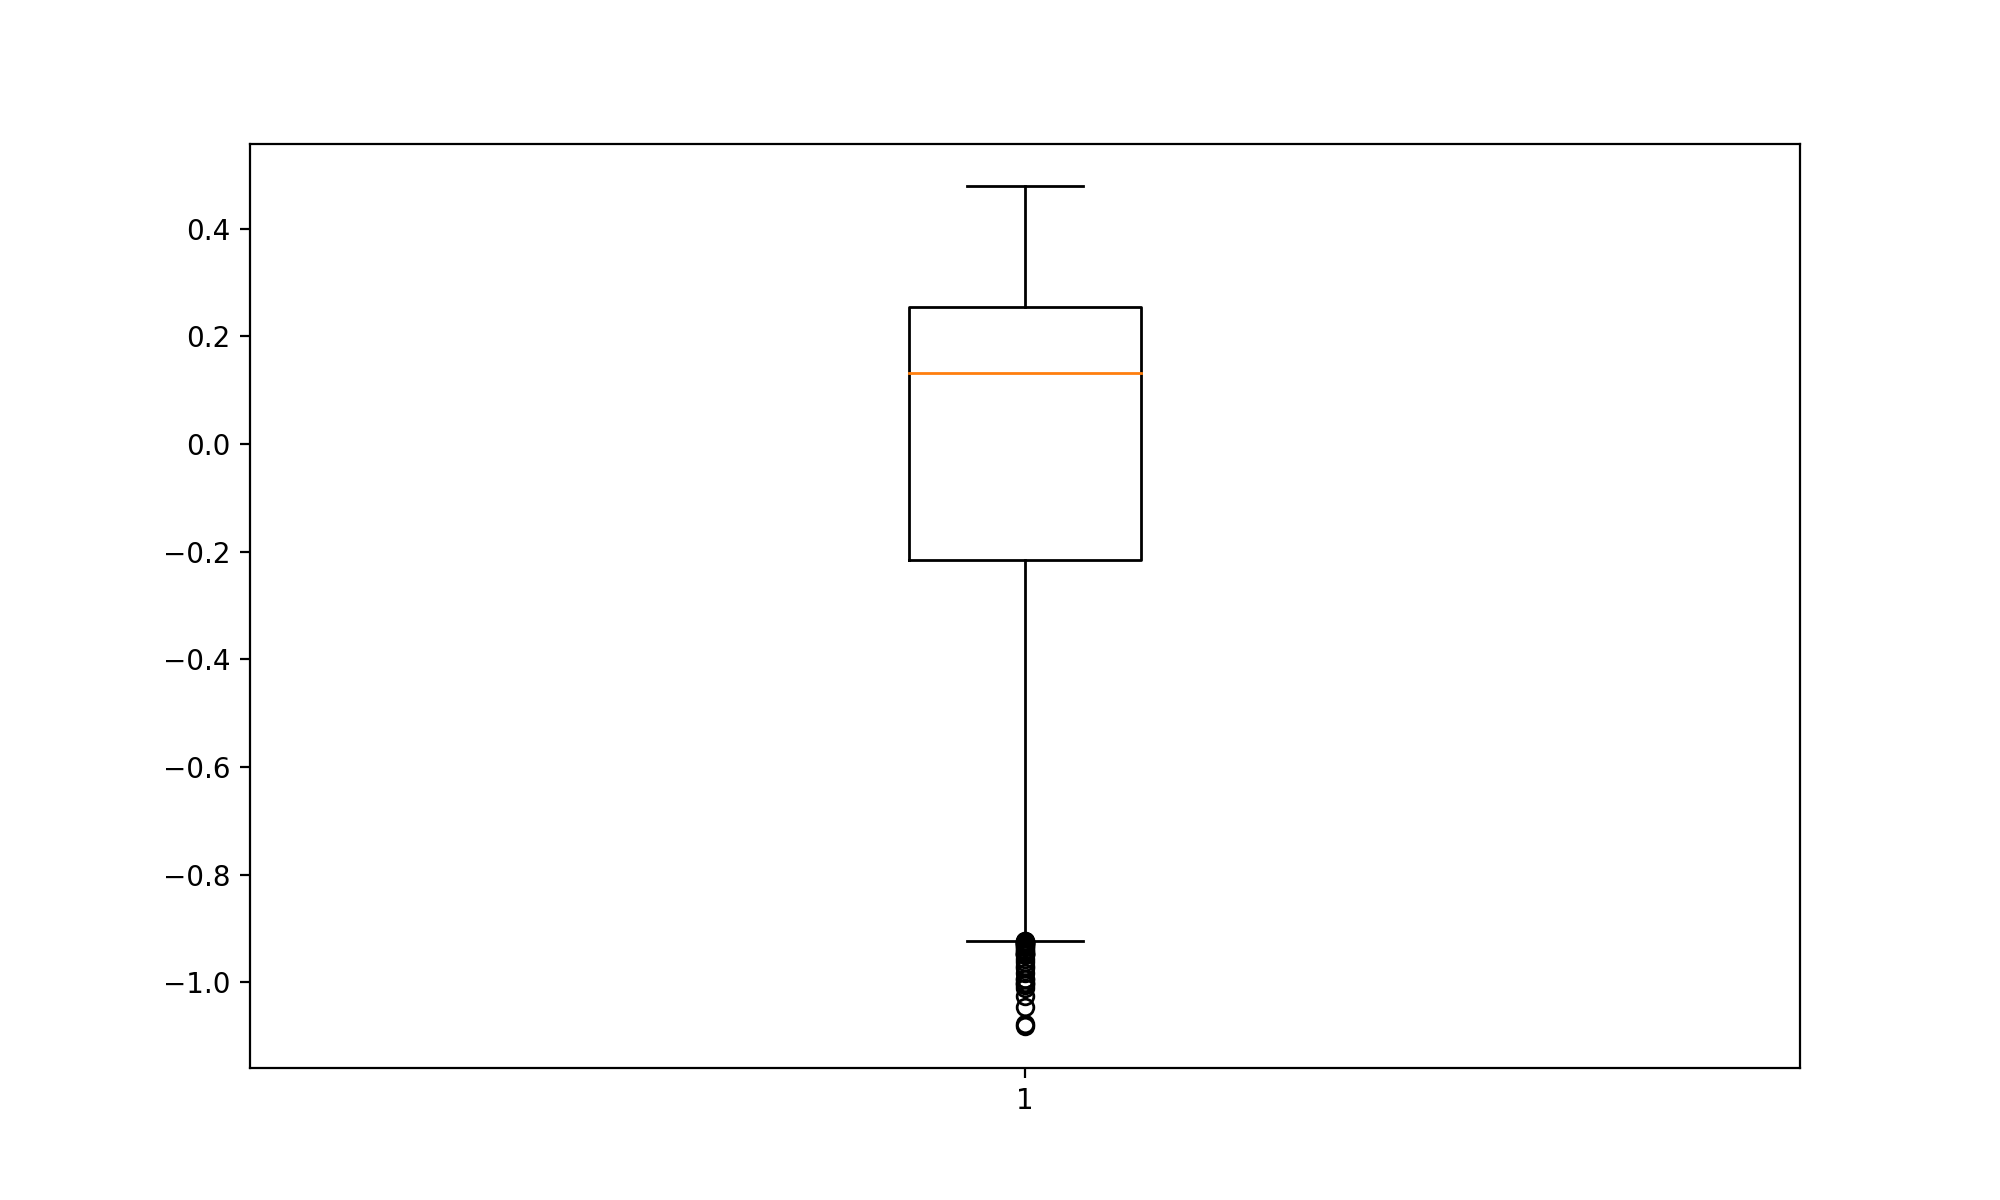

In [133]:
fig = plt.figure(figsize =(10, 6))
plt.boxplot(avg_homogeneity_random_sampling_from_target)
plt.show()

<IPython.core.display.Javascript object>


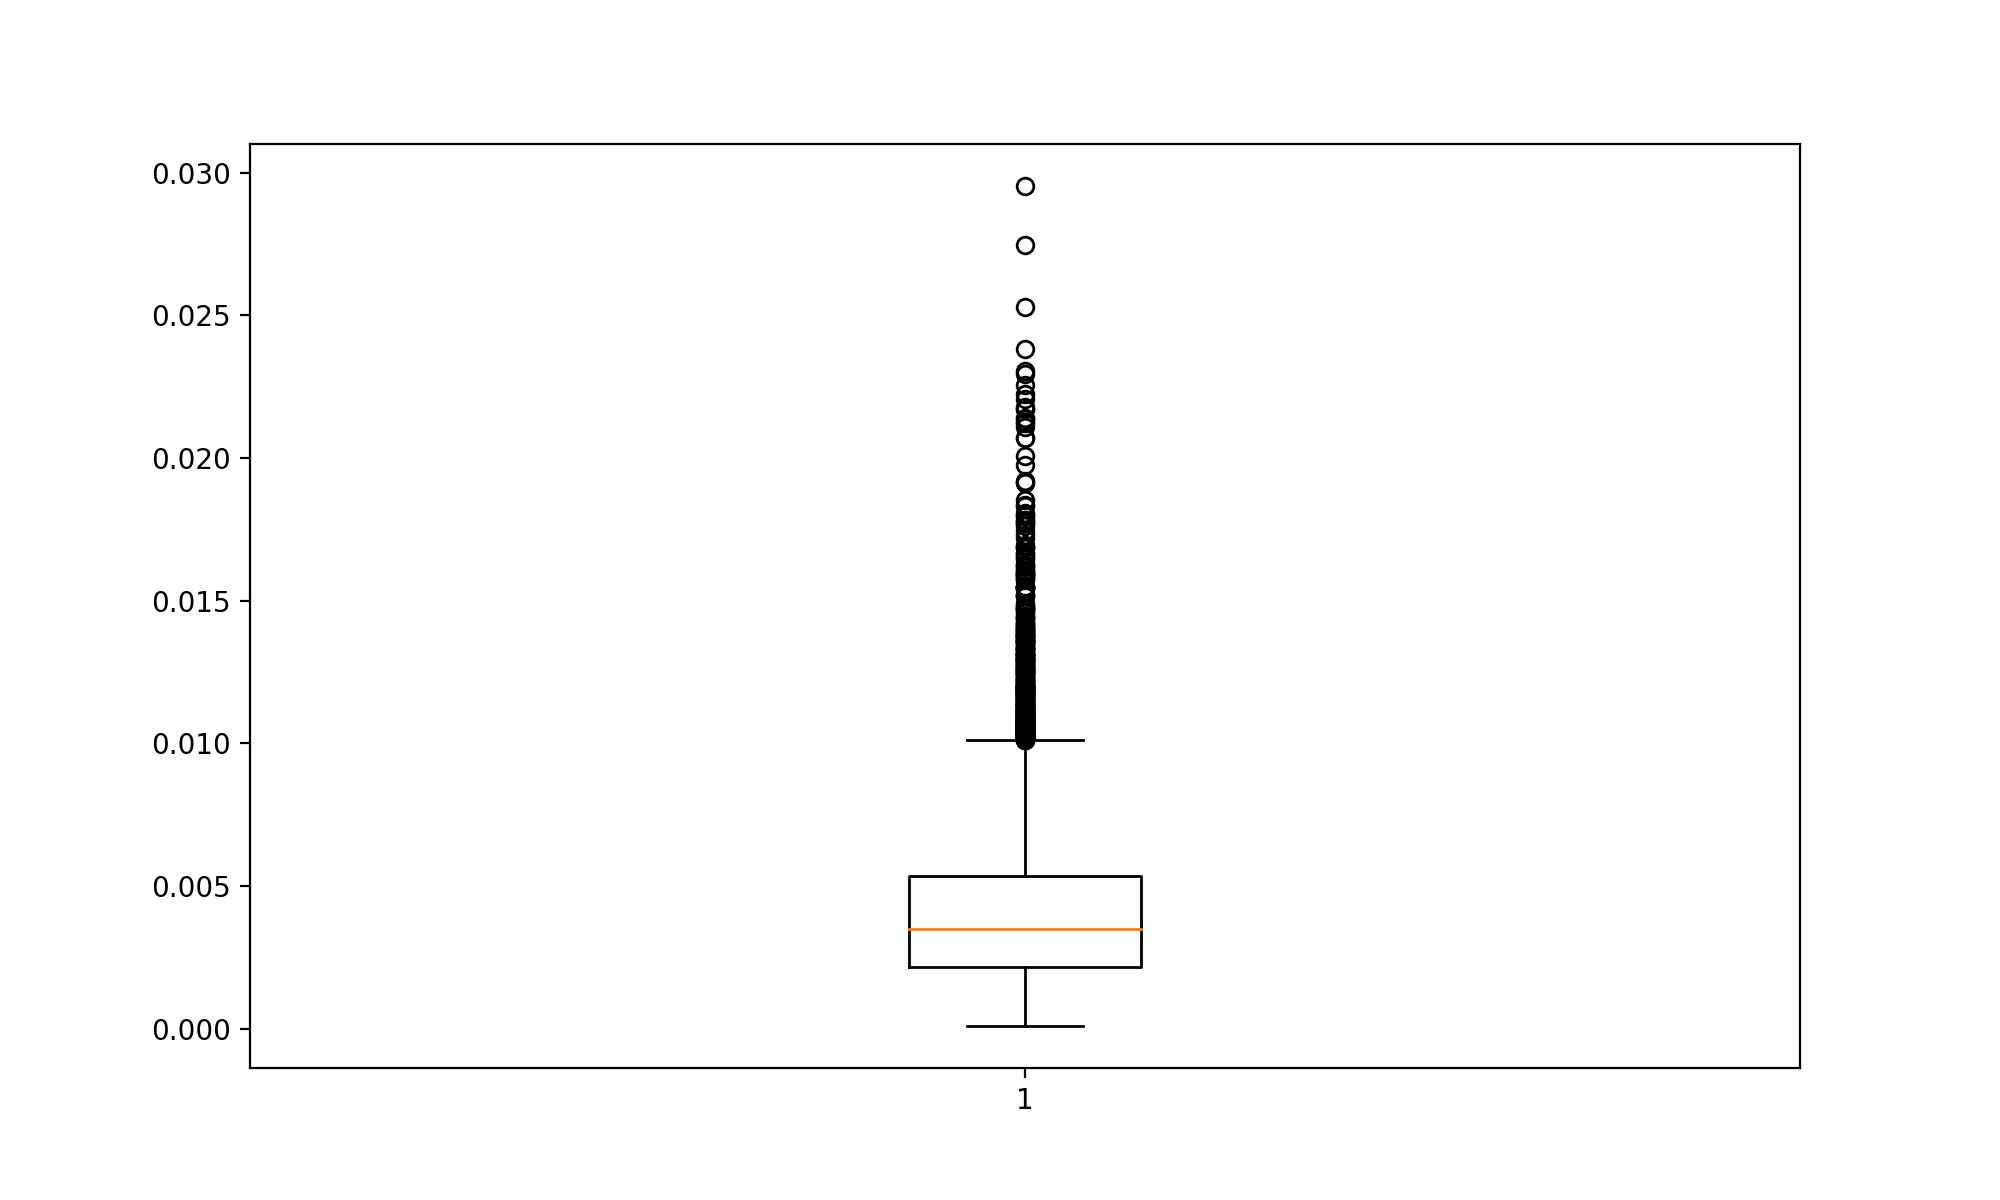

In [134]:
fig = plt.figure(figsize =(10, 6))
plt.boxplot(avg_weighted_homogeneity_random_sampling_from_target)
plt.show()

## Running DBScan on the data

**<font color='red'>(Note: for 500k data points, the DBScan crushes the computer) </font>**

In [ ]:
start_time = time.time()
dbscan = DBSCAN(eps=0.3)
X["Cluster_DBscan"] = dbscan.fit_predict(X.drop(columns = ['dim_user_gid']))
X["Cluster_DBscan"] = X["Cluster_DBscan"].astype("category")
end_time = time.time()
print(end_time - start_time)

In [ ]:
sb.set(style = "darkgrid")

fig = plt.figure(figsize = (12, 10))
ax = Axes3D(fig)
ax = fig.add_subplot(111, projection = '3d')

x = X['level']
y = X['Last_30D_Gross_Sink']
z = X['Life_Time_Login_Days']

ax.set_xlabel("level")
ax.set_ylabel("Last_30D_Gross_Sink")
ax.set_zlabel("Life_Time_Login_Days")

ax.scatter(x, y, z, c = X['Cluster'])

plt.show()